# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

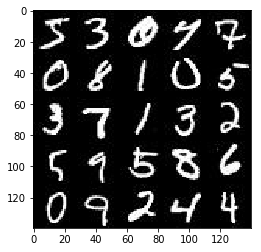

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

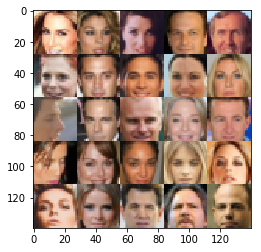

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [34]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # first convolution is 14x14x56
        out1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        out1 = tf.maximum(out1 * alpha, out1)
        
        # second convolution is 7x7x112
        out2 = tf.layers.conv2d(out1, 128, 4, strides=2, padding='same')
        out2 = tf.layers.batch_normalization(out2, training=True)
        out2 = tf.maximum(out2 * alpha, out2)
        
        # third convolution is also 4x4x256
        out3 = tf.layers.conv2d(out2, 256, 2, strides=2, padding='same')
        out3 = tf.layers.batch_normalization(out3, training=True)
        out3 = tf.maximum(out3 * alpha, out3)
        
        flat = tf.reshape(out3, (-1, 4*4*256))
        
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out2.shape)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #print(z.shape)
        # 4x4x256
        out1 = tf.layers.dense(z, 7*7*256)
        out1 = tf.reshape(out1, (-1, 7, 7, 256))
        out1 = tf.layers.batch_normalization(out1, training=is_train)
        out1 = tf.maximum(out1 * alpha, out1)
        out1 = tf.nn.dropout(out1, 0.95)
        
        # Deconvolution 12x12x112
        out2 = tf.layers.conv2d_transpose(out1, 128, 5, strides=2, padding='same')
        out2 = tf.layers.batch_normalization(out2, training=is_train)
        out2 = tf.maximum(out2 * alpha, out2)
        out2 = tf.nn.dropout(out2, 0.9)
        
        # Deconvolution 24x24x56
        out3 = tf.layers.conv2d_transpose(out2, 64, 5, strides=2, padding='same')
        out3 = tf.layers.batch_normalization(out3, training=is_train)
        out3 = tf.maximum(out3 * alpha, out3)
        out3 = tf.nn.dropout(out3, 0.9)
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(out3, out_channel_dim, 5, strides=1, padding='same')
        
        
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [37]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [38]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tf_vars = tf.trainable_variables()
    dis_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in tf_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [40]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate_tf = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    current_evl = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("Current Epoch {}...".format(epoch_i+1))
            for batch_images in get_batches(batch_size):
                current_evl += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                if data_image_mode == 'RGB':
                    batch_images *= 1.0
                
                # Running optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real: batch_images})
                
                if current_evl%5 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Current Epoch {}/{} \n".format(epoch_i+1, epoch_count),
                          "Discriminator Loss is : {:.4f} \n".format(train_loss_d),
                          "Generator Loss is : {:.4f}".format(train_loss_g))
                    if current_evl%25 == 0:
                        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    print("\n\n")   
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Current Epoch 1...
Current Epoch 1/2 
 Discriminator Loss is : 1.4186 
 Generator Loss is : 0.5243



Current Epoch 1/2 
 Discriminator Loss is : 1.4621 
 Generator Loss is : 0.5012



Current Epoch 1/2 
 Discriminator Loss is : 0.8216 
 Generator Loss is : 1.1246



Current Epoch 1/2 
 Discriminator Loss is : 1.0584 
 Generator Loss is : 0.8761



Current Epoch 1/2 
 Discriminator Loss is : 0.9211 
 Generator Loss is : 1.1794


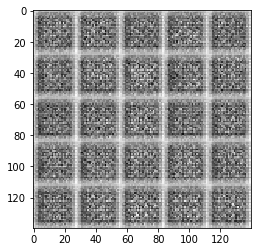




Current Epoch 1/2 
 Discriminator Loss is : 0.9295 
 Generator Loss is : 1.2205



Current Epoch 1/2 
 Discriminator Loss is : 0.9794 
 Generator Loss is : 1.0792



Current Epoch 1/2 
 Discriminator Loss is : 1.0548 
 Generator Loss is : 0.9522



Current Epoch 1/2 
 Discriminator Loss is : 1.0142 
 Generator Loss is : 0.9713



Current Epoch 1/2 
 Discriminator Loss is : 1.0478 
 Generator Loss is : 0.8866


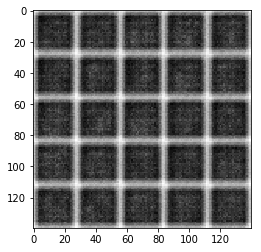




Current Epoch 1/2 
 Discriminator Loss is : 0.9221 
 Generator Loss is : 1.1927



Current Epoch 1/2 
 Discriminator Loss is : 0.9586 
 Generator Loss is : 1.2711



Current Epoch 1/2 
 Discriminator Loss is : 0.9817 
 Generator Loss is : 1.2272



Current Epoch 1/2 
 Discriminator Loss is : 0.8433 
 Generator Loss is : 1.4357



Current Epoch 1/2 
 Discriminator Loss is : 0.9501 
 Generator Loss is : 0.8870


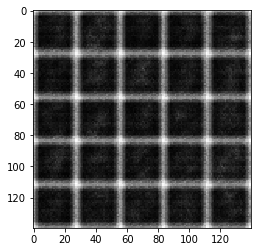




Current Epoch 1/2 
 Discriminator Loss is : 1.0859 
 Generator Loss is : 0.8803



Current Epoch 1/2 
 Discriminator Loss is : 0.9009 
 Generator Loss is : 1.0355



Current Epoch 1/2 
 Discriminator Loss is : 0.9629 
 Generator Loss is : 2.2025



Current Epoch 1/2 
 Discriminator Loss is : 0.8461 
 Generator Loss is : 1.1886



Current Epoch 1/2 
 Discriminator Loss is : 0.8602 
 Generator Loss is : 1.0206


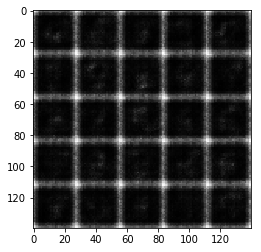




Current Epoch 1/2 
 Discriminator Loss is : 0.7343 
 Generator Loss is : 1.8659



Current Epoch 1/2 
 Discriminator Loss is : 0.6715 
 Generator Loss is : 1.5340



Current Epoch 1/2 
 Discriminator Loss is : 0.6534 
 Generator Loss is : 2.1581



Current Epoch 1/2 
 Discriminator Loss is : 0.8410 
 Generator Loss is : 1.0835



Current Epoch 1/2 
 Discriminator Loss is : 0.6656 
 Generator Loss is : 2.2170


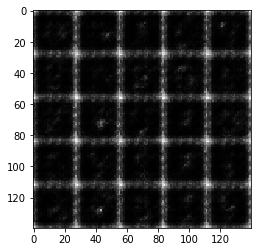




Current Epoch 1/2 
 Discriminator Loss is : 0.6194 
 Generator Loss is : 2.3316



Current Epoch 1/2 
 Discriminator Loss is : 0.5815 
 Generator Loss is : 1.6980



Current Epoch 1/2 
 Discriminator Loss is : 0.5530 
 Generator Loss is : 1.9802



Current Epoch 1/2 
 Discriminator Loss is : 0.6379 
 Generator Loss is : 1.9662



Current Epoch 1/2 
 Discriminator Loss is : 0.8785 
 Generator Loss is : 0.9472


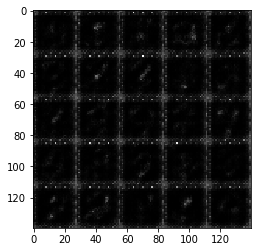




Current Epoch 1/2 
 Discriminator Loss is : 0.5584 
 Generator Loss is : 2.0952



Current Epoch 1/2 
 Discriminator Loss is : 0.5640 
 Generator Loss is : 1.7386



Current Epoch 1/2 
 Discriminator Loss is : 0.6355 
 Generator Loss is : 1.4431



Current Epoch 1/2 
 Discriminator Loss is : 0.5379 
 Generator Loss is : 1.9984



Current Epoch 1/2 
 Discriminator Loss is : 0.4948 
 Generator Loss is : 2.2998


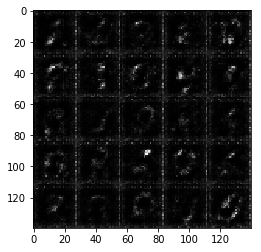




Current Epoch 1/2 
 Discriminator Loss is : 0.5741 
 Generator Loss is : 1.7014



Current Epoch 1/2 
 Discriminator Loss is : 0.4889 
 Generator Loss is : 2.3408



Current Epoch 1/2 
 Discriminator Loss is : 0.5187 
 Generator Loss is : 1.9803



Current Epoch 1/2 
 Discriminator Loss is : 0.5083 
 Generator Loss is : 2.2087



Current Epoch 1/2 
 Discriminator Loss is : 0.5189 
 Generator Loss is : 2.3373


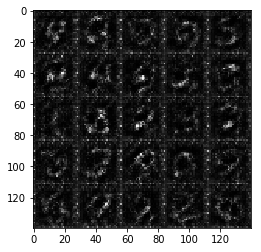




Current Epoch 1/2 
 Discriminator Loss is : 0.6053 
 Generator Loss is : 1.5761



Current Epoch 1/2 
 Discriminator Loss is : 0.5891 
 Generator Loss is : 1.6048



Current Epoch 1/2 
 Discriminator Loss is : 0.4810 
 Generator Loss is : 2.4784



Current Epoch 1/2 
 Discriminator Loss is : 0.4190 
 Generator Loss is : 2.7468



Current Epoch 1/2 
 Discriminator Loss is : 0.8802 
 Generator Loss is : 0.9971


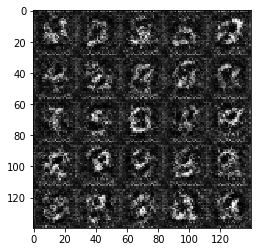




Current Epoch 1/2 
 Discriminator Loss is : 0.4883 
 Generator Loss is : 2.2504



Current Epoch 1/2 
 Discriminator Loss is : 0.4246 
 Generator Loss is : 3.1797



Current Epoch 1/2 
 Discriminator Loss is : 0.8085 
 Generator Loss is : 1.0577



Current Epoch 1/2 
 Discriminator Loss is : 0.7389 
 Generator Loss is : 1.1868



Current Epoch 1/2 
 Discriminator Loss is : 1.0939 
 Generator Loss is : 0.7384


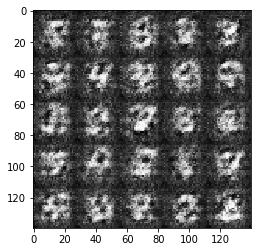




Current Epoch 1/2 
 Discriminator Loss is : 0.4100 
 Generator Loss is : 3.2220



Current Epoch 1/2 
 Discriminator Loss is : 0.4859 
 Generator Loss is : 2.3420



Current Epoch 1/2 
 Discriminator Loss is : 0.4814 
 Generator Loss is : 2.5417



Current Epoch 1/2 
 Discriminator Loss is : 0.4332 
 Generator Loss is : 2.6292



Current Epoch 1/2 
 Discriminator Loss is : 2.2562 
 Generator Loss is : 0.2142


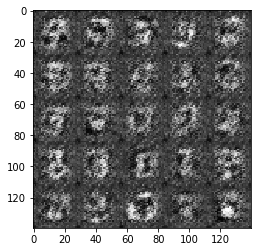




Current Epoch 1/2 
 Discriminator Loss is : 1.2201 
 Generator Loss is : 2.4894



Current Epoch 1/2 
 Discriminator Loss is : 0.7728 
 Generator Loss is : 1.2039



Current Epoch 1/2 
 Discriminator Loss is : 0.9926 
 Generator Loss is : 3.6725



Current Epoch 1/2 
 Discriminator Loss is : 1.5443 
 Generator Loss is : 3.4638



Current Epoch 1/2 
 Discriminator Loss is : 0.6315 
 Generator Loss is : 3.5072


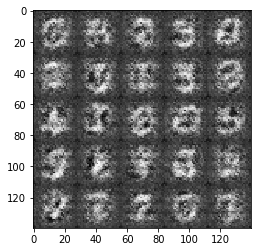




Current Epoch 1/2 
 Discriminator Loss is : 0.5989 
 Generator Loss is : 1.6582



Current Epoch 1/2 
 Discriminator Loss is : 1.0412 
 Generator Loss is : 3.4570



Current Epoch 1/2 
 Discriminator Loss is : 0.5360 
 Generator Loss is : 2.5245



Current Epoch 1/2 
 Discriminator Loss is : 1.1168 
 Generator Loss is : 0.6876



Current Epoch 1/2 
 Discriminator Loss is : 0.5851 
 Generator Loss is : 2.2639


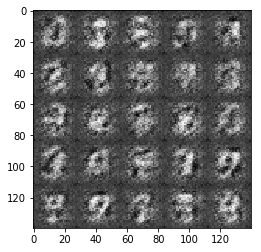




Current Epoch 1/2 
 Discriminator Loss is : 0.6719 
 Generator Loss is : 2.7067



Current Epoch 1/2 
 Discriminator Loss is : 0.5696 
 Generator Loss is : 2.3849



Current Epoch 1/2 
 Discriminator Loss is : 0.5546 
 Generator Loss is : 3.1160



Current Epoch 1/2 
 Discriminator Loss is : 0.5872 
 Generator Loss is : 1.6600



Current Epoch 1/2 
 Discriminator Loss is : 0.5175 
 Generator Loss is : 2.1850


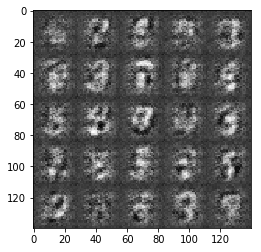




Current Epoch 1/2 
 Discriminator Loss is : 0.5616 
 Generator Loss is : 2.5715



Current Epoch 1/2 
 Discriminator Loss is : 0.5912 
 Generator Loss is : 1.7680



Current Epoch 1/2 
 Discriminator Loss is : 0.5954 
 Generator Loss is : 3.7252



Current Epoch 1/2 
 Discriminator Loss is : 0.5394 
 Generator Loss is : 2.1452



Current Epoch 1/2 
 Discriminator Loss is : 0.7320 
 Generator Loss is : 2.6601


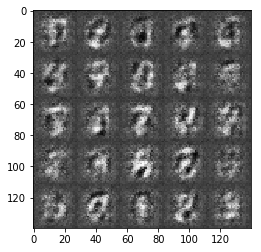




Current Epoch 1/2 
 Discriminator Loss is : 0.5409 
 Generator Loss is : 1.9382



Current Epoch 1/2 
 Discriminator Loss is : 0.5054 
 Generator Loss is : 2.5561



Current Epoch 1/2 
 Discriminator Loss is : 0.9452 
 Generator Loss is : 0.8269



Current Epoch 1/2 
 Discriminator Loss is : 0.5714 
 Generator Loss is : 2.0167



Current Epoch 1/2 
 Discriminator Loss is : 0.6303 
 Generator Loss is : 1.4906


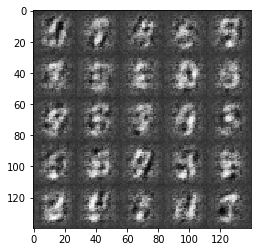




Current Epoch 1/2 
 Discriminator Loss is : 0.5814 
 Generator Loss is : 2.4704



Current Epoch 1/2 
 Discriminator Loss is : 0.5387 
 Generator Loss is : 2.3772



Current Epoch 1/2 
 Discriminator Loss is : 1.4471 
 Generator Loss is : 3.8242



Current Epoch 1/2 
 Discriminator Loss is : 0.5730 
 Generator Loss is : 2.0844



Current Epoch 1/2 
 Discriminator Loss is : 0.5575 
 Generator Loss is : 2.1053


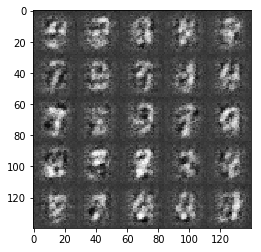




Current Epoch 1/2 
 Discriminator Loss is : 0.5338 
 Generator Loss is : 2.1085



Current Epoch 1/2 
 Discriminator Loss is : 0.5237 
 Generator Loss is : 2.5197



Current Epoch 1/2 
 Discriminator Loss is : 0.5043 
 Generator Loss is : 2.2250



Current Epoch 1/2 
 Discriminator Loss is : 0.6233 
 Generator Loss is : 1.5127



Current Epoch 1/2 
 Discriminator Loss is : 0.5049 
 Generator Loss is : 2.1899


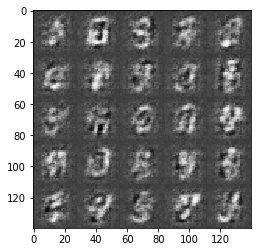




Current Epoch 1/2 
 Discriminator Loss is : 0.7638 
 Generator Loss is : 1.1359



Current Epoch 1/2 
 Discriminator Loss is : 0.5348 
 Generator Loss is : 2.0763



Current Epoch 1/2 
 Discriminator Loss is : 0.7058 
 Generator Loss is : 3.0080



Current Epoch 1/2 
 Discriminator Loss is : 0.5116 
 Generator Loss is : 2.2911



Current Epoch 1/2 
 Discriminator Loss is : 0.5062 
 Generator Loss is : 2.1745


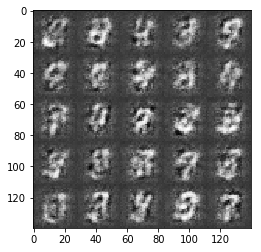




Current Epoch 1/2 
 Discriminator Loss is : 0.5201 
 Generator Loss is : 2.6630



Current Epoch 1/2 
 Discriminator Loss is : 0.5697 
 Generator Loss is : 1.7155



Current Epoch 1/2 
 Discriminator Loss is : 0.5373 
 Generator Loss is : 2.6081



Current Epoch 1/2 
 Discriminator Loss is : 0.4716 
 Generator Loss is : 2.7568



Current Epoch 1/2 
 Discriminator Loss is : 0.5115 
 Generator Loss is : 2.1653


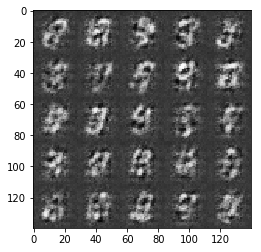




Current Epoch 1/2 
 Discriminator Loss is : 0.4692 
 Generator Loss is : 2.5110



Current Epoch 1/2 
 Discriminator Loss is : 0.5970 
 Generator Loss is : 1.7010



Current Epoch 1/2 
 Discriminator Loss is : 0.4918 
 Generator Loss is : 2.6650



Current Epoch 1/2 
 Discriminator Loss is : 0.5136 
 Generator Loss is : 2.3879



Current Epoch 1/2 
 Discriminator Loss is : 0.4557 
 Generator Loss is : 2.9493


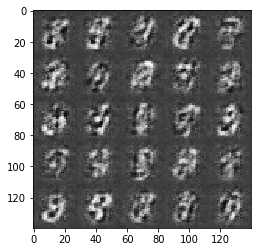




Current Epoch 1/2 
 Discriminator Loss is : 0.5471 
 Generator Loss is : 3.1205



Current Epoch 1/2 
 Discriminator Loss is : 0.4713 
 Generator Loss is : 2.8401



Current Epoch 1/2 
 Discriminator Loss is : 0.4492 
 Generator Loss is : 2.6731



Current Epoch 1/2 
 Discriminator Loss is : 0.5206 
 Generator Loss is : 2.5651



Current Epoch 1/2 
 Discriminator Loss is : 0.4848 
 Generator Loss is : 2.4159


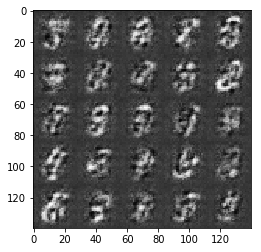




Current Epoch 1/2 
 Discriminator Loss is : 0.5433 
 Generator Loss is : 1.9426



Current Epoch 1/2 
 Discriminator Loss is : 0.6479 
 Generator Loss is : 1.4680



Current Epoch 1/2 
 Discriminator Loss is : 0.4594 
 Generator Loss is : 2.8392



Current Epoch 1/2 
 Discriminator Loss is : 0.5648 
 Generator Loss is : 1.7570



Current Epoch 1/2 
 Discriminator Loss is : 0.4707 
 Generator Loss is : 2.3310


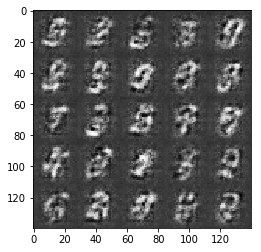




Current Epoch 1/2 
 Discriminator Loss is : 0.4654 
 Generator Loss is : 2.4508



Current Epoch 1/2 
 Discriminator Loss is : 0.5070 
 Generator Loss is : 2.0402



Current Epoch 1/2 
 Discriminator Loss is : 0.4555 
 Generator Loss is : 3.0176



Current Epoch 1/2 
 Discriminator Loss is : 0.6553 
 Generator Loss is : 1.4031



Current Epoch 1/2 
 Discriminator Loss is : 0.4360 
 Generator Loss is : 2.7671


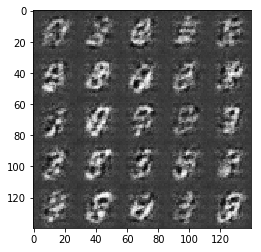




Current Epoch 1/2 
 Discriminator Loss is : 0.4605 
 Generator Loss is : 2.8871



Current Epoch 1/2 
 Discriminator Loss is : 0.4622 
 Generator Loss is : 2.4802



Current Epoch 1/2 
 Discriminator Loss is : 0.4789 
 Generator Loss is : 2.2625



Current Epoch 1/2 
 Discriminator Loss is : 0.4209 
 Generator Loss is : 3.2794



Current Epoch 1/2 
 Discriminator Loss is : 0.6245 
 Generator Loss is : 1.5632


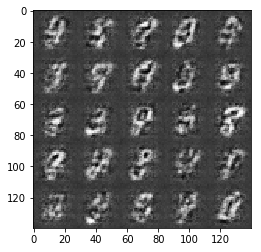




Current Epoch 1/2 
 Discriminator Loss is : 0.4355 
 Generator Loss is : 2.7810



Current Epoch 1/2 
 Discriminator Loss is : 0.3896 
 Generator Loss is : 3.4092



Current Epoch 1/2 
 Discriminator Loss is : 0.4137 
 Generator Loss is : 3.0758



Current Epoch 1/2 
 Discriminator Loss is : 0.4551 
 Generator Loss is : 2.3882



Current Epoch 1/2 
 Discriminator Loss is : 0.6096 
 Generator Loss is : 1.6287


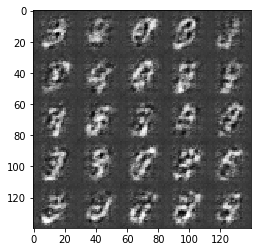




Current Epoch 1/2 
 Discriminator Loss is : 0.4022 
 Generator Loss is : 3.1547



Current Epoch 1/2 
 Discriminator Loss is : 0.4747 
 Generator Loss is : 2.2538



Current Epoch 1/2 
 Discriminator Loss is : 0.4283 
 Generator Loss is : 2.8911



Current Epoch 1/2 
 Discriminator Loss is : 0.4374 
 Generator Loss is : 2.9450



Current Epoch 1/2 
 Discriminator Loss is : 0.4246 
 Generator Loss is : 2.9814


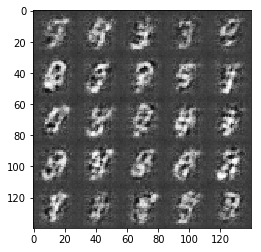




Current Epoch 1/2 
 Discriminator Loss is : 0.5435 
 Generator Loss is : 1.8498



Current Epoch 1/2 
 Discriminator Loss is : 0.4227 
 Generator Loss is : 2.7682



Current Epoch 1/2 
 Discriminator Loss is : 0.4024 
 Generator Loss is : 3.1912



Current Epoch 1/2 
 Discriminator Loss is : 0.4037 
 Generator Loss is : 3.0291



Current Epoch 1/2 
 Discriminator Loss is : 0.4144 
 Generator Loss is : 2.9247


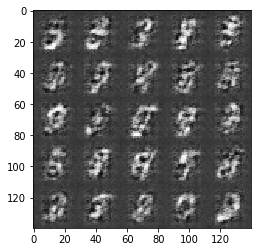




Current Epoch 1/2 
 Discriminator Loss is : 0.7233 
 Generator Loss is : 4.9558



Current Epoch 1/2 
 Discriminator Loss is : 0.4425 
 Generator Loss is : 2.6936



Current Epoch 1/2 
 Discriminator Loss is : 0.5588 
 Generator Loss is : 1.7667



Current Epoch 1/2 
 Discriminator Loss is : 0.4268 
 Generator Loss is : 2.8469



Current Epoch 1/2 
 Discriminator Loss is : 0.4639 
 Generator Loss is : 2.6370


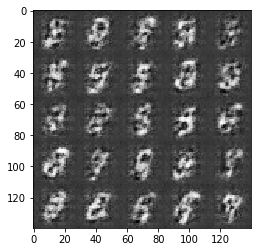




Current Epoch 1/2 
 Discriminator Loss is : 0.4070 
 Generator Loss is : 3.4164



Current Epoch 1/2 
 Discriminator Loss is : 0.5077 
 Generator Loss is : 3.8517



Current Epoch 1/2 
 Discriminator Loss is : 0.3814 
 Generator Loss is : 3.6138



Current Epoch 1/2 
 Discriminator Loss is : 0.4260 
 Generator Loss is : 2.6138



Current Epoch 1/2 
 Discriminator Loss is : 0.6457 
 Generator Loss is : 4.4079


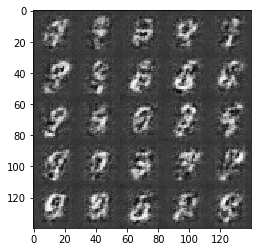




Current Epoch 1/2 
 Discriminator Loss is : 0.4874 
 Generator Loss is : 2.7723



Current Epoch 1/2 
 Discriminator Loss is : 0.4310 
 Generator Loss is : 3.0652



Current Epoch 1/2 
 Discriminator Loss is : 0.4632 
 Generator Loss is : 2.7520



Current Epoch 1/2 
 Discriminator Loss is : 0.4417 
 Generator Loss is : 2.4958



Current Epoch 1/2 
 Discriminator Loss is : 0.3832 
 Generator Loss is : 3.2227


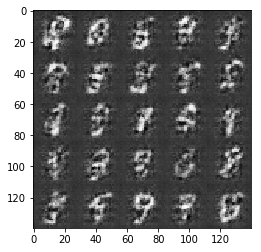




Current Epoch 1/2 
 Discriminator Loss is : 0.4964 
 Generator Loss is : 2.1722



Current Epoch 1/2 
 Discriminator Loss is : 0.4422 
 Generator Loss is : 2.4520



Current Epoch 1/2 
 Discriminator Loss is : 0.4167 
 Generator Loss is : 2.9124



Current Epoch 1/2 
 Discriminator Loss is : 0.3955 
 Generator Loss is : 3.0919



Current Epoch 1/2 
 Discriminator Loss is : 0.4063 
 Generator Loss is : 2.9674


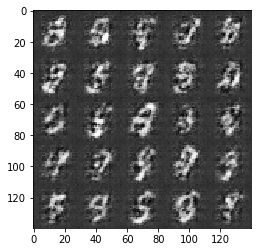




Current Epoch 1/2 
 Discriminator Loss is : 0.4952 
 Generator Loss is : 2.1317



Current Epoch 1/2 
 Discriminator Loss is : 0.3720 
 Generator Loss is : 4.0609



Current Epoch 1/2 
 Discriminator Loss is : 0.3837 
 Generator Loss is : 3.6755



Current Epoch 1/2 
 Discriminator Loss is : 0.3833 
 Generator Loss is : 3.3982



Current Epoch 1/2 
 Discriminator Loss is : 0.5106 
 Generator Loss is : 1.9634


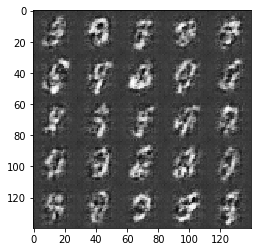




Current Epoch 1/2 
 Discriminator Loss is : 0.4274 
 Generator Loss is : 3.3140



Current Epoch 1/2 
 Discriminator Loss is : 0.4203 
 Generator Loss is : 2.8727



Current Epoch 1/2 
 Discriminator Loss is : 1.3903 
 Generator Loss is : 5.8750



Current Epoch 1/2 
 Discriminator Loss is : 0.5641 
 Generator Loss is : 1.7816



Current Epoch 1/2 
 Discriminator Loss is : 0.4702 
 Generator Loss is : 2.3114


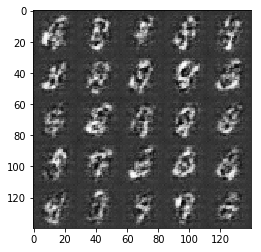




Current Epoch 1/2 
 Discriminator Loss is : 0.4662 
 Generator Loss is : 2.2502



Current Epoch 1/2 
 Discriminator Loss is : 0.4183 
 Generator Loss is : 2.7232



Current Epoch 1/2 
 Discriminator Loss is : 0.4998 
 Generator Loss is : 3.4312



Current Epoch 1/2 
 Discriminator Loss is : 0.4211 
 Generator Loss is : 2.8917



Current Epoch 1/2 
 Discriminator Loss is : 0.4291 
 Generator Loss is : 3.0102


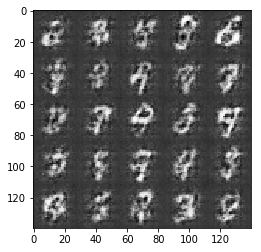




Current Epoch 1/2 
 Discriminator Loss is : 0.4169 
 Generator Loss is : 2.7496



Current Epoch 1/2 
 Discriminator Loss is : 0.4787 
 Generator Loss is : 2.1993



Current Epoch 1/2 
 Discriminator Loss is : 0.4924 
 Generator Loss is : 2.1401



Current Epoch 1/2 
 Discriminator Loss is : 0.3986 
 Generator Loss is : 3.0450



Current Epoch 1/2 
 Discriminator Loss is : 0.3985 
 Generator Loss is : 3.1519


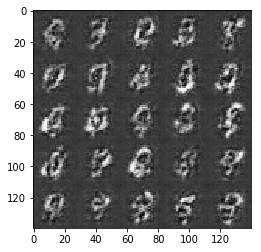




Current Epoch 1/2 
 Discriminator Loss is : 0.3774 
 Generator Loss is : 3.5162



Current Epoch 1/2 
 Discriminator Loss is : 0.4086 
 Generator Loss is : 2.8942



Current Epoch 1/2 
 Discriminator Loss is : 0.4567 
 Generator Loss is : 2.4181



Current Epoch 1/2 
 Discriminator Loss is : 0.3729 
 Generator Loss is : 3.9733



Current Epoch 1/2 
 Discriminator Loss is : 0.4321 
 Generator Loss is : 2.6362


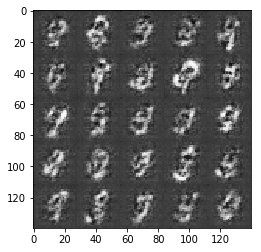




Current Epoch 1/2 
 Discriminator Loss is : 0.4068 
 Generator Loss is : 2.8464



Current Epoch 1/2 
 Discriminator Loss is : 0.3877 
 Generator Loss is : 3.3120



Current Epoch 2...
Current Epoch 2/2 
 Discriminator Loss is : 0.4458 
 Generator Loss is : 2.4561



Current Epoch 2/2 
 Discriminator Loss is : 0.5355 
 Generator Loss is : 2.0014



Current Epoch 2/2 
 Discriminator Loss is : 0.3999 
 Generator Loss is : 3.1914


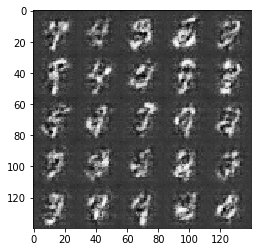




Current Epoch 2/2 
 Discriminator Loss is : 0.3927 
 Generator Loss is : 3.1855



Current Epoch 2/2 
 Discriminator Loss is : 0.3819 
 Generator Loss is : 3.4519



Current Epoch 2/2 
 Discriminator Loss is : 0.4134 
 Generator Loss is : 2.8269



Current Epoch 2/2 
 Discriminator Loss is : 0.4023 
 Generator Loss is : 3.2542



Current Epoch 2/2 
 Discriminator Loss is : 0.3885 
 Generator Loss is : 3.9337


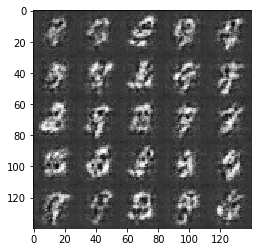




Current Epoch 2/2 
 Discriminator Loss is : 0.4835 
 Generator Loss is : 2.1623



Current Epoch 2/2 
 Discriminator Loss is : 0.3775 
 Generator Loss is : 3.6251



Current Epoch 2/2 
 Discriminator Loss is : 0.3949 
 Generator Loss is : 3.6500



Current Epoch 2/2 
 Discriminator Loss is : 0.3867 
 Generator Loss is : 3.2137



Current Epoch 2/2 
 Discriminator Loss is : 0.3916 
 Generator Loss is : 3.2663


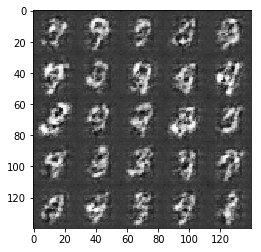




Current Epoch 2/2 
 Discriminator Loss is : 0.3902 
 Generator Loss is : 3.1642



Current Epoch 2/2 
 Discriminator Loss is : 0.3811 
 Generator Loss is : 3.5084



Current Epoch 2/2 
 Discriminator Loss is : 0.3747 
 Generator Loss is : 3.9806



Current Epoch 2/2 
 Discriminator Loss is : 0.3696 
 Generator Loss is : 3.8607



Current Epoch 2/2 
 Discriminator Loss is : 0.3870 
 Generator Loss is : 3.2566


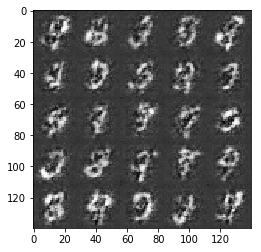




Current Epoch 2/2 
 Discriminator Loss is : 0.3978 
 Generator Loss is : 3.0898



Current Epoch 2/2 
 Discriminator Loss is : 0.3868 
 Generator Loss is : 3.3724



Current Epoch 2/2 
 Discriminator Loss is : 0.4150 
 Generator Loss is : 3.8711



Current Epoch 2/2 
 Discriminator Loss is : 0.4029 
 Generator Loss is : 3.3968



Current Epoch 2/2 
 Discriminator Loss is : 0.3720 
 Generator Loss is : 3.8593


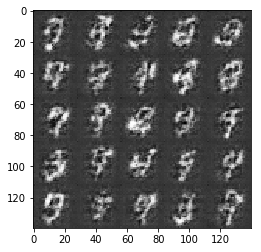




Current Epoch 2/2 
 Discriminator Loss is : 0.3956 
 Generator Loss is : 3.1461



Current Epoch 2/2 
 Discriminator Loss is : 0.3652 
 Generator Loss is : 3.8552



Current Epoch 2/2 
 Discriminator Loss is : 0.5081 
 Generator Loss is : 2.0478



Current Epoch 2/2 
 Discriminator Loss is : 0.4447 
 Generator Loss is : 3.4254



Current Epoch 2/2 
 Discriminator Loss is : 0.3872 
 Generator Loss is : 3.2252


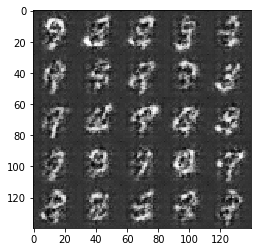




Current Epoch 2/2 
 Discriminator Loss is : 0.3628 
 Generator Loss is : 4.0516



Current Epoch 2/2 
 Discriminator Loss is : 0.3904 
 Generator Loss is : 3.2247



Current Epoch 2/2 
 Discriminator Loss is : 0.3856 
 Generator Loss is : 3.3325



Current Epoch 2/2 
 Discriminator Loss is : 0.3721 
 Generator Loss is : 3.6973



Current Epoch 2/2 
 Discriminator Loss is : 0.4456 
 Generator Loss is : 2.5773


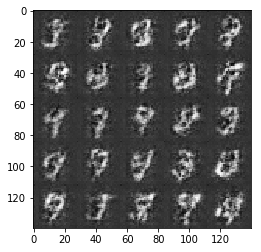




Current Epoch 2/2 
 Discriminator Loss is : 0.3754 
 Generator Loss is : 3.7193



Current Epoch 2/2 
 Discriminator Loss is : 0.3613 
 Generator Loss is : 4.1745



Current Epoch 2/2 
 Discriminator Loss is : 0.4101 
 Generator Loss is : 2.8984



Current Epoch 2/2 
 Discriminator Loss is : 0.3859 
 Generator Loss is : 3.2686



Current Epoch 2/2 
 Discriminator Loss is : 0.3840 
 Generator Loss is : 3.3791


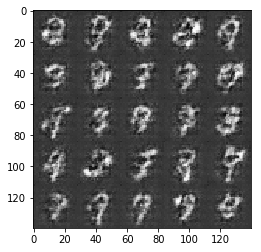




Current Epoch 2/2 
 Discriminator Loss is : 0.4045 
 Generator Loss is : 2.9922



Current Epoch 2/2 
 Discriminator Loss is : 0.3734 
 Generator Loss is : 3.9541



Current Epoch 2/2 
 Discriminator Loss is : 0.3756 
 Generator Loss is : 3.6936



Current Epoch 2/2 
 Discriminator Loss is : 0.3607 
 Generator Loss is : 4.2046



Current Epoch 2/2 
 Discriminator Loss is : 0.3890 
 Generator Loss is : 3.1437


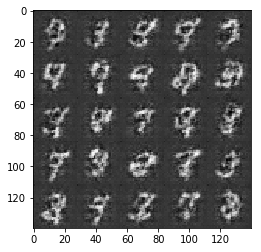




Current Epoch 2/2 
 Discriminator Loss is : 0.4058 
 Generator Loss is : 2.9720



Current Epoch 2/2 
 Discriminator Loss is : 0.3827 
 Generator Loss is : 3.7051



Current Epoch 2/2 
 Discriminator Loss is : 0.3726 
 Generator Loss is : 3.4831



Current Epoch 2/2 
 Discriminator Loss is : 0.3694 
 Generator Loss is : 3.6421



Current Epoch 2/2 
 Discriminator Loss is : 0.3936 
 Generator Loss is : 3.4449


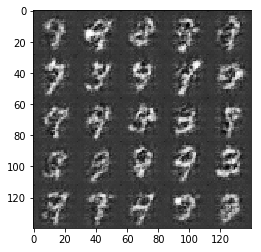




Current Epoch 2/2 
 Discriminator Loss is : 0.5881 
 Generator Loss is : 1.8992



Current Epoch 2/2 
 Discriminator Loss is : 0.4048 
 Generator Loss is : 2.9250



Current Epoch 2/2 
 Discriminator Loss is : 0.3878 
 Generator Loss is : 3.8966



Current Epoch 2/2 
 Discriminator Loss is : 0.3865 
 Generator Loss is : 3.3774



Current Epoch 2/2 
 Discriminator Loss is : 0.4909 
 Generator Loss is : 2.2657


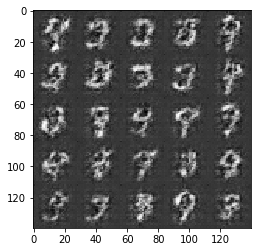




Current Epoch 2/2 
 Discriminator Loss is : 0.3721 
 Generator Loss is : 4.5500



Current Epoch 2/2 
 Discriminator Loss is : 0.3801 
 Generator Loss is : 4.1616



Current Epoch 2/2 
 Discriminator Loss is : 0.4305 
 Generator Loss is : 2.6812



Current Epoch 2/2 
 Discriminator Loss is : 0.3709 
 Generator Loss is : 3.6938



Current Epoch 2/2 
 Discriminator Loss is : 0.3806 
 Generator Loss is : 3.8232


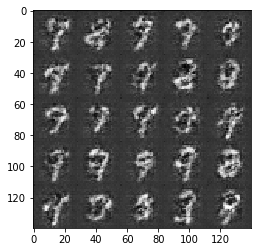




Current Epoch 2/2 
 Discriminator Loss is : 0.4063 
 Generator Loss is : 3.2038



Current Epoch 2/2 
 Discriminator Loss is : 0.3647 
 Generator Loss is : 3.8417



Current Epoch 2/2 
 Discriminator Loss is : 0.3608 
 Generator Loss is : 4.0017



Current Epoch 2/2 
 Discriminator Loss is : 0.3829 
 Generator Loss is : 3.5982



Current Epoch 2/2 
 Discriminator Loss is : 0.3946 
 Generator Loss is : 3.8483


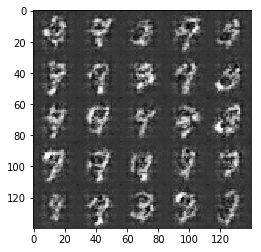




Current Epoch 2/2 
 Discriminator Loss is : 0.3686 
 Generator Loss is : 3.8254



Current Epoch 2/2 
 Discriminator Loss is : 0.3663 
 Generator Loss is : 3.8796



Current Epoch 2/2 
 Discriminator Loss is : 0.5226 
 Generator Loss is : 2.1260



Current Epoch 2/2 
 Discriminator Loss is : 0.4799 
 Generator Loss is : 2.1885



Current Epoch 2/2 
 Discriminator Loss is : 0.3728 
 Generator Loss is : 4.7589


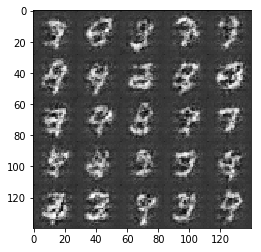




Current Epoch 2/2 
 Discriminator Loss is : 0.3960 
 Generator Loss is : 3.0704



Current Epoch 2/2 
 Discriminator Loss is : 0.4267 
 Generator Loss is : 2.6356



Current Epoch 2/2 
 Discriminator Loss is : 0.3542 
 Generator Loss is : 4.2773



Current Epoch 2/2 
 Discriminator Loss is : 0.3640 
 Generator Loss is : 4.1334



Current Epoch 2/2 
 Discriminator Loss is : 1.0730 
 Generator Loss is : 1.2918


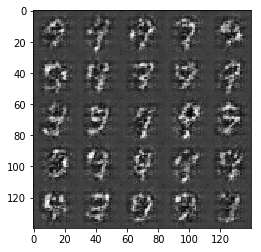




Current Epoch 2/2 
 Discriminator Loss is : 0.6919 
 Generator Loss is : 1.6919



Current Epoch 2/2 
 Discriminator Loss is : 0.4402 
 Generator Loss is : 3.2023



Current Epoch 2/2 
 Discriminator Loss is : 0.4494 
 Generator Loss is : 2.7266



Current Epoch 2/2 
 Discriminator Loss is : 0.5057 
 Generator Loss is : 2.1593



Current Epoch 2/2 
 Discriminator Loss is : 0.4533 
 Generator Loss is : 2.6114


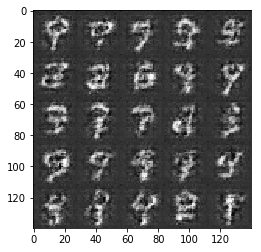




Current Epoch 2/2 
 Discriminator Loss is : 0.3976 
 Generator Loss is : 3.0532



Current Epoch 2/2 
 Discriminator Loss is : 0.4161 
 Generator Loss is : 2.7916



Current Epoch 2/2 
 Discriminator Loss is : 0.4400 
 Generator Loss is : 2.7135



Current Epoch 2/2 
 Discriminator Loss is : 0.3821 
 Generator Loss is : 3.2576



Current Epoch 2/2 
 Discriminator Loss is : 0.4299 
 Generator Loss is : 2.6259


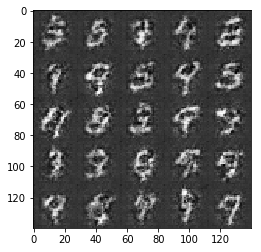




Current Epoch 2/2 
 Discriminator Loss is : 0.4077 
 Generator Loss is : 3.0774



Current Epoch 2/2 
 Discriminator Loss is : 0.3842 
 Generator Loss is : 3.5112



Current Epoch 2/2 
 Discriminator Loss is : 0.3984 
 Generator Loss is : 2.9843



Current Epoch 2/2 
 Discriminator Loss is : 0.3938 
 Generator Loss is : 3.1684



Current Epoch 2/2 
 Discriminator Loss is : 0.4281 
 Generator Loss is : 2.6157


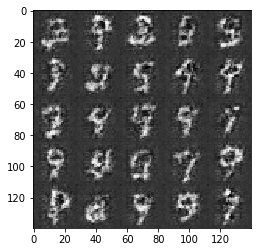




Current Epoch 2/2 
 Discriminator Loss is : 0.3916 
 Generator Loss is : 3.0390



Current Epoch 2/2 
 Discriminator Loss is : 0.3880 
 Generator Loss is : 3.1928



Current Epoch 2/2 
 Discriminator Loss is : 0.3969 
 Generator Loss is : 3.2681



Current Epoch 2/2 
 Discriminator Loss is : 0.4409 
 Generator Loss is : 2.4868



Current Epoch 2/2 
 Discriminator Loss is : 0.4345 
 Generator Loss is : 2.5359


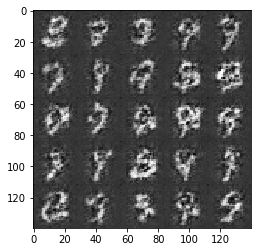




Current Epoch 2/2 
 Discriminator Loss is : 0.3800 
 Generator Loss is : 3.5412



Current Epoch 2/2 
 Discriminator Loss is : 0.4029 
 Generator Loss is : 3.7253



Current Epoch 2/2 
 Discriminator Loss is : 0.3805 
 Generator Loss is : 3.3570



Current Epoch 2/2 
 Discriminator Loss is : 0.3957 
 Generator Loss is : 3.0352



Current Epoch 2/2 
 Discriminator Loss is : 0.4268 
 Generator Loss is : 2.6328


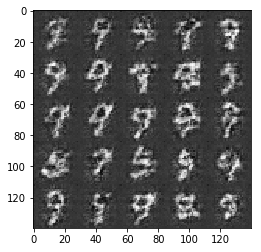




Current Epoch 2/2 
 Discriminator Loss is : 0.4062 
 Generator Loss is : 2.8542



Current Epoch 2/2 
 Discriminator Loss is : 0.3937 
 Generator Loss is : 3.1090



Current Epoch 2/2 
 Discriminator Loss is : 0.3723 
 Generator Loss is : 3.4797



Current Epoch 2/2 
 Discriminator Loss is : 0.3890 
 Generator Loss is : 3.1942



Current Epoch 2/2 
 Discriminator Loss is : 0.3821 
 Generator Loss is : 3.2750


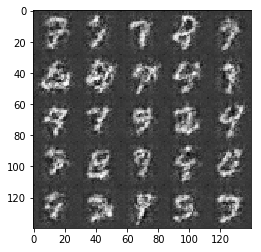




Current Epoch 2/2 
 Discriminator Loss is : 0.4207 
 Generator Loss is : 3.4787



Current Epoch 2/2 
 Discriminator Loss is : 0.3857 
 Generator Loss is : 3.3804



Current Epoch 2/2 
 Discriminator Loss is : 0.3531 
 Generator Loss is : 4.1368



Current Epoch 2/2 
 Discriminator Loss is : 0.3919 
 Generator Loss is : 3.1387



Current Epoch 2/2 
 Discriminator Loss is : 0.3784 
 Generator Loss is : 3.4721


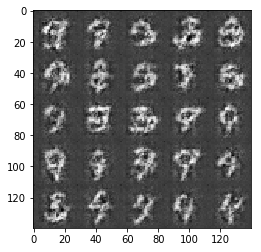




Current Epoch 2/2 
 Discriminator Loss is : 0.3719 
 Generator Loss is : 3.6281



Current Epoch 2/2 
 Discriminator Loss is : 0.3555 
 Generator Loss is : 4.2647



Current Epoch 2/2 
 Discriminator Loss is : 0.4603 
 Generator Loss is : 4.0698



Current Epoch 2/2 
 Discriminator Loss is : 0.3843 
 Generator Loss is : 3.2117



Current Epoch 2/2 
 Discriminator Loss is : 0.3612 
 Generator Loss is : 4.8786


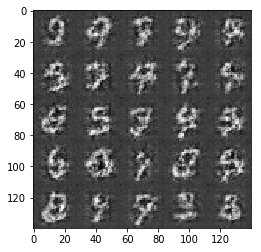




Current Epoch 2/2 
 Discriminator Loss is : 0.4831 
 Generator Loss is : 2.4527



Current Epoch 2/2 
 Discriminator Loss is : 0.4141 
 Generator Loss is : 2.8588



Current Epoch 2/2 
 Discriminator Loss is : 0.3682 
 Generator Loss is : 3.7087



Current Epoch 2/2 
 Discriminator Loss is : 0.3615 
 Generator Loss is : 4.0967



Current Epoch 2/2 
 Discriminator Loss is : 0.3869 
 Generator Loss is : 3.1724


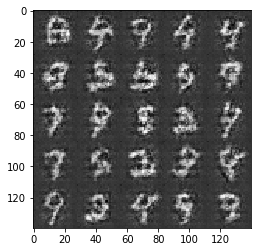




Current Epoch 2/2 
 Discriminator Loss is : 0.3830 
 Generator Loss is : 3.5524



Current Epoch 2/2 
 Discriminator Loss is : 0.3520 
 Generator Loss is : 4.5379



Current Epoch 2/2 
 Discriminator Loss is : 0.3514 
 Generator Loss is : 4.6798



Current Epoch 2/2 
 Discriminator Loss is : 0.3938 
 Generator Loss is : 3.0548



Current Epoch 2/2 
 Discriminator Loss is : 0.4026 
 Generator Loss is : 2.9891


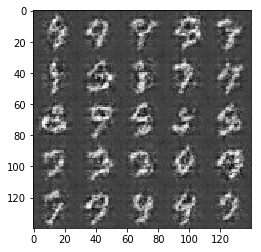




Current Epoch 2/2 
 Discriminator Loss is : 0.3834 
 Generator Loss is : 4.5823



Current Epoch 2/2 
 Discriminator Loss is : 0.3690 
 Generator Loss is : 3.5971



Current Epoch 2/2 
 Discriminator Loss is : 0.3853 
 Generator Loss is : 3.4088



Current Epoch 2/2 
 Discriminator Loss is : 0.3781 
 Generator Loss is : 3.5626



Current Epoch 2/2 
 Discriminator Loss is : 0.3605 
 Generator Loss is : 3.9246


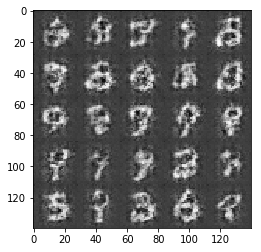




Current Epoch 2/2 
 Discriminator Loss is : 0.4080 
 Generator Loss is : 3.0117



Current Epoch 2/2 
 Discriminator Loss is : 0.3843 
 Generator Loss is : 3.8045



Current Epoch 2/2 
 Discriminator Loss is : 0.3597 
 Generator Loss is : 3.9789



Current Epoch 2/2 
 Discriminator Loss is : 0.4201 
 Generator Loss is : 2.7215



Current Epoch 2/2 
 Discriminator Loss is : 0.3875 
 Generator Loss is : 4.7523


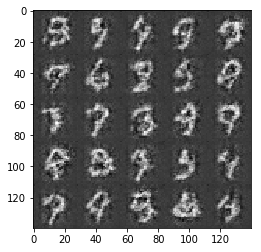




Current Epoch 2/2 
 Discriminator Loss is : 0.3676 
 Generator Loss is : 3.9181



Current Epoch 2/2 
 Discriminator Loss is : 0.4151 
 Generator Loss is : 2.7025



Current Epoch 2/2 
 Discriminator Loss is : 0.3649 
 Generator Loss is : 3.9974



Current Epoch 2/2 
 Discriminator Loss is : 0.4347 
 Generator Loss is : 2.6611



Current Epoch 2/2 
 Discriminator Loss is : 0.3741 
 Generator Loss is : 3.6743


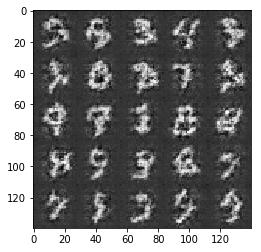




Current Epoch 2/2 
 Discriminator Loss is : 0.3636 
 Generator Loss is : 3.8781



Current Epoch 2/2 
 Discriminator Loss is : 0.3907 
 Generator Loss is : 3.0751



Current Epoch 2/2 
 Discriminator Loss is : 0.3772 
 Generator Loss is : 4.3617



Current Epoch 2/2 
 Discriminator Loss is : 0.3797 
 Generator Loss is : 3.4318



Current Epoch 2/2 
 Discriminator Loss is : 0.3915 
 Generator Loss is : 3.2629


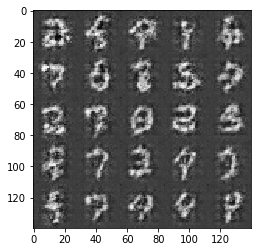




Current Epoch 2/2 
 Discriminator Loss is : 0.3603 
 Generator Loss is : 3.7947



Current Epoch 2/2 
 Discriminator Loss is : 0.4785 
 Generator Loss is : 2.4826



Current Epoch 2/2 
 Discriminator Loss is : 0.3646 
 Generator Loss is : 3.8445



Current Epoch 2/2 
 Discriminator Loss is : 0.3670 
 Generator Loss is : 3.8697



Current Epoch 2/2 
 Discriminator Loss is : 0.3708 
 Generator Loss is : 3.5156


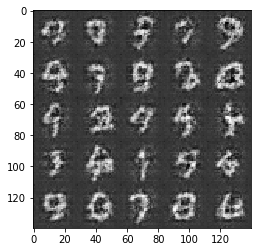




Current Epoch 2/2 
 Discriminator Loss is : 0.3658 
 Generator Loss is : 3.8519



Current Epoch 2/2 
 Discriminator Loss is : 0.3806 
 Generator Loss is : 3.5199



Current Epoch 2/2 
 Discriminator Loss is : 0.3584 
 Generator Loss is : 4.9268



Current Epoch 2/2 
 Discriminator Loss is : 0.3964 
 Generator Loss is : 3.0556



Current Epoch 2/2 
 Discriminator Loss is : 0.4061 
 Generator Loss is : 2.8550


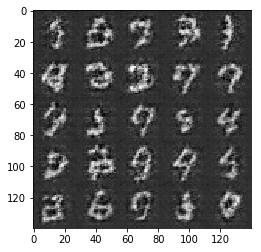




Current Epoch 2/2 
 Discriminator Loss is : 0.3539 
 Generator Loss is : 4.3838



Current Epoch 2/2 
 Discriminator Loss is : 0.8971 
 Generator Loss is : 1.1798



Current Epoch 2/2 
 Discriminator Loss is : 9.8059 
 Generator Loss is : 9.4006



Current Epoch 2/2 
 Discriminator Loss is : 0.9217 
 Generator Loss is : 1.0658



Current Epoch 2/2 
 Discriminator Loss is : 0.8548 
 Generator Loss is : 1.1002


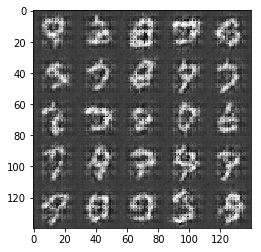




Current Epoch 2/2 
 Discriminator Loss is : 0.6026 
 Generator Loss is : 2.0701



Current Epoch 2/2 
 Discriminator Loss is : 0.5271 
 Generator Loss is : 2.1846



Current Epoch 2/2 
 Discriminator Loss is : 0.5247 
 Generator Loss is : 2.0492



Current Epoch 2/2 
 Discriminator Loss is : 0.4977 
 Generator Loss is : 2.3862



Current Epoch 2/2 
 Discriminator Loss is : 0.5128 
 Generator Loss is : 2.0678


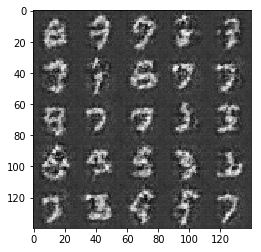




Current Epoch 2/2 
 Discriminator Loss is : 0.5176 
 Generator Loss is : 2.0263



Current Epoch 2/2 
 Discriminator Loss is : 0.4191 
 Generator Loss is : 3.0341



Current Epoch 2/2 
 Discriminator Loss is : 0.4641 
 Generator Loss is : 2.4045



Current Epoch 2/2 
 Discriminator Loss is : 0.4496 
 Generator Loss is : 2.4541



Current Epoch 2/2 
 Discriminator Loss is : 0.3879 
 Generator Loss is : 3.5026


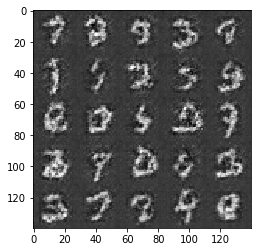




Current Epoch 2/2 
 Discriminator Loss is : 0.4626 
 Generator Loss is : 2.4401



Current Epoch 2/2 
 Discriminator Loss is : 0.4776 
 Generator Loss is : 2.1540



Current Epoch 2/2 
 Discriminator Loss is : 0.3632 
 Generator Loss is : 3.9695



Current Epoch 2/2 
 Discriminator Loss is : 1.1599 
 Generator Loss is : 0.7057



Current Epoch 2/2 
 Discriminator Loss is : 0.5007 
 Generator Loss is : 2.7808


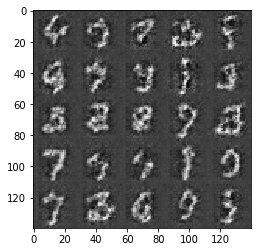




Current Epoch 2/2 
 Discriminator Loss is : 1.0197 
 Generator Loss is : 1.2497



Current Epoch 2/2 
 Discriminator Loss is : 0.5254 
 Generator Loss is : 2.7264



Current Epoch 2/2 
 Discriminator Loss is : 0.4690 
 Generator Loss is : 2.6350



Current Epoch 2/2 
 Discriminator Loss is : 0.5403 
 Generator Loss is : 2.0395



Current Epoch 2/2 
 Discriminator Loss is : 0.4119 
 Generator Loss is : 3.0568


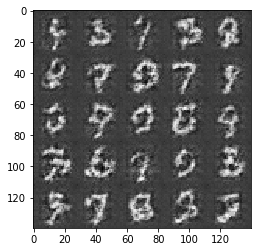




Current Epoch 2/2 
 Discriminator Loss is : 0.4687 
 Generator Loss is : 2.5049



Current Epoch 2/2 
 Discriminator Loss is : 0.4115 
 Generator Loss is : 2.9261



Current Epoch 2/2 
 Discriminator Loss is : 0.4379 
 Generator Loss is : 2.8299



Current Epoch 2/2 
 Discriminator Loss is : 0.4246 
 Generator Loss is : 2.7087



Current Epoch 2/2 
 Discriminator Loss is : 0.4456 
 Generator Loss is : 2.7664


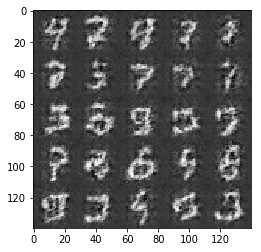




Current Epoch 2/2 
 Discriminator Loss is : 0.4142 
 Generator Loss is : 2.8200



Current Epoch 2/2 
 Discriminator Loss is : 0.3992 
 Generator Loss is : 3.0198



Current Epoch 2/2 
 Discriminator Loss is : 0.4079 
 Generator Loss is : 2.9741



Current Epoch 2/2 
 Discriminator Loss is : 0.4034 
 Generator Loss is : 2.9458





In [215]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Current Epoch 1...
Current Epoch 1/1 
 Discriminator Loss is : 1.5436 
 Generator Loss is : 0.4953



Current Epoch 1/1 
 Discriminator Loss is : 1.3714 
 Generator Loss is : 0.5897



Current Epoch 1/1 
 Discriminator Loss is : 1.2348 
 Generator Loss is : 0.7530



Current Epoch 1/1 
 Discriminator Loss is : 1.0971 
 Generator Loss is : 0.9096



Current Epoch 1/1 
 Discriminator Loss is : 1.1912 
 Generator Loss is : 0.8698


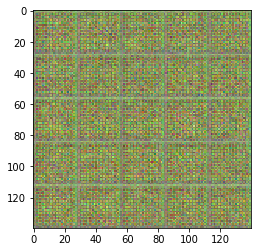




Current Epoch 1/1 
 Discriminator Loss is : 1.0581 
 Generator Loss is : 1.0036



Current Epoch 1/1 
 Discriminator Loss is : 0.9753 
 Generator Loss is : 1.1766



Current Epoch 1/1 
 Discriminator Loss is : 0.9545 
 Generator Loss is : 1.1704



Current Epoch 1/1 
 Discriminator Loss is : 0.9160 
 Generator Loss is : 1.4912



Current Epoch 1/1 
 Discriminator Loss is : 0.8072 
 Generator Loss is : 1.5339


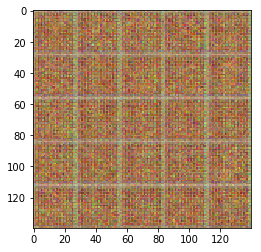




Current Epoch 1/1 
 Discriminator Loss is : 0.7709 
 Generator Loss is : 1.5987



Current Epoch 1/1 
 Discriminator Loss is : 0.6822 
 Generator Loss is : 1.6527



Current Epoch 1/1 
 Discriminator Loss is : 0.7522 
 Generator Loss is : 1.7097



Current Epoch 1/1 
 Discriminator Loss is : 0.6724 
 Generator Loss is : 1.8828



Current Epoch 1/1 
 Discriminator Loss is : 0.7156 
 Generator Loss is : 1.7823


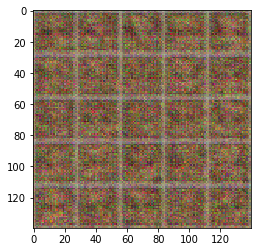




Current Epoch 1/1 
 Discriminator Loss is : 0.6404 
 Generator Loss is : 1.8915



Current Epoch 1/1 
 Discriminator Loss is : 0.7084 
 Generator Loss is : 1.9421



Current Epoch 1/1 
 Discriminator Loss is : 0.6881 
 Generator Loss is : 1.7626



Current Epoch 1/1 
 Discriminator Loss is : 0.6395 
 Generator Loss is : 2.0082



Current Epoch 1/1 
 Discriminator Loss is : 0.6246 
 Generator Loss is : 2.0535


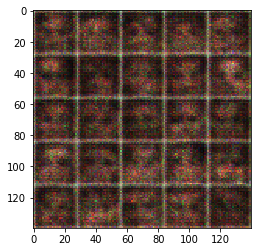




Current Epoch 1/1 
 Discriminator Loss is : 0.6394 
 Generator Loss is : 2.1098



Current Epoch 1/1 
 Discriminator Loss is : 0.5837 
 Generator Loss is : 2.1655



Current Epoch 1/1 
 Discriminator Loss is : 0.6337 
 Generator Loss is : 1.9899



Current Epoch 1/1 
 Discriminator Loss is : 0.5322 
 Generator Loss is : 2.4570



Current Epoch 1/1 
 Discriminator Loss is : 0.5470 
 Generator Loss is : 2.2912


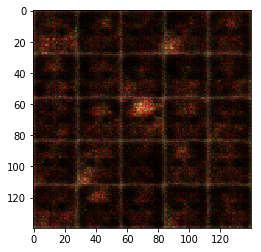




Current Epoch 1/1 
 Discriminator Loss is : 0.5664 
 Generator Loss is : 2.1384



Current Epoch 1/1 
 Discriminator Loss is : 0.5433 
 Generator Loss is : 2.2805



Current Epoch 1/1 
 Discriminator Loss is : 0.5224 
 Generator Loss is : 2.4754



Current Epoch 1/1 
 Discriminator Loss is : 0.5496 
 Generator Loss is : 2.3095



Current Epoch 1/1 
 Discriminator Loss is : 0.4920 
 Generator Loss is : 2.5141


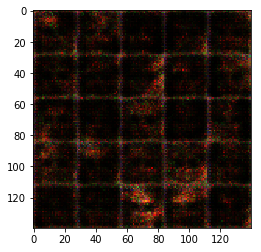




Current Epoch 1/1 
 Discriminator Loss is : 0.5021 
 Generator Loss is : 2.4355



Current Epoch 1/1 
 Discriminator Loss is : 0.4592 
 Generator Loss is : 2.7336



Current Epoch 1/1 
 Discriminator Loss is : 0.4670 
 Generator Loss is : 2.9452



Current Epoch 1/1 
 Discriminator Loss is : 0.4236 
 Generator Loss is : 3.1112



Current Epoch 1/1 
 Discriminator Loss is : 0.4297 
 Generator Loss is : 2.9366


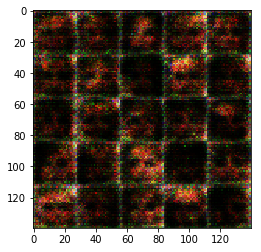




Current Epoch 1/1 
 Discriminator Loss is : 0.4183 
 Generator Loss is : 3.0383



Current Epoch 1/1 
 Discriminator Loss is : 0.4184 
 Generator Loss is : 3.0492



Current Epoch 1/1 
 Discriminator Loss is : 0.4409 
 Generator Loss is : 3.0889



Current Epoch 1/1 
 Discriminator Loss is : 0.4011 
 Generator Loss is : 3.3197



Current Epoch 1/1 
 Discriminator Loss is : 0.3972 
 Generator Loss is : 3.3507


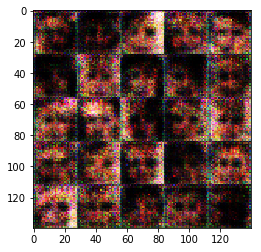




Current Epoch 1/1 
 Discriminator Loss is : 0.3941 
 Generator Loss is : 3.2859



Current Epoch 1/1 
 Discriminator Loss is : 0.4069 
 Generator Loss is : 3.2850



Current Epoch 1/1 
 Discriminator Loss is : 0.3859 
 Generator Loss is : 3.5172



Current Epoch 1/1 
 Discriminator Loss is : 0.3872 
 Generator Loss is : 3.4018



Current Epoch 1/1 
 Discriminator Loss is : 0.3898 
 Generator Loss is : 3.3618


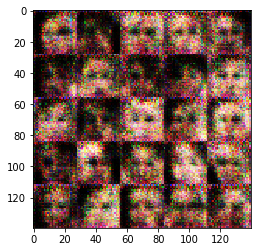




Current Epoch 1/1 
 Discriminator Loss is : 0.4105 
 Generator Loss is : 3.0208



Current Epoch 1/1 
 Discriminator Loss is : 0.3902 
 Generator Loss is : 3.2268



Current Epoch 1/1 
 Discriminator Loss is : 0.3907 
 Generator Loss is : 3.3479



Current Epoch 1/1 
 Discriminator Loss is : 0.3743 
 Generator Loss is : 3.7097



Current Epoch 1/1 
 Discriminator Loss is : 0.3897 
 Generator Loss is : 3.6072


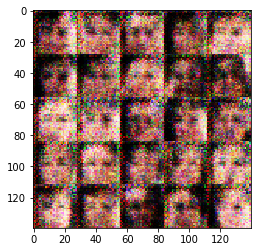




Current Epoch 1/1 
 Discriminator Loss is : 0.3910 
 Generator Loss is : 3.2868



Current Epoch 1/1 
 Discriminator Loss is : 0.3660 
 Generator Loss is : 3.8347



Current Epoch 1/1 
 Discriminator Loss is : 0.3766 
 Generator Loss is : 3.6014



Current Epoch 1/1 
 Discriminator Loss is : 0.3762 
 Generator Loss is : 3.8282



Current Epoch 1/1 
 Discriminator Loss is : 0.3740 
 Generator Loss is : 4.1538


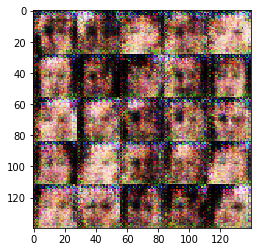




Current Epoch 1/1 
 Discriminator Loss is : 0.3824 
 Generator Loss is : 3.4846



Current Epoch 1/1 
 Discriminator Loss is : 0.3650 
 Generator Loss is : 4.0874



Current Epoch 1/1 
 Discriminator Loss is : 0.3669 
 Generator Loss is : 4.0773



Current Epoch 1/1 
 Discriminator Loss is : 0.3675 
 Generator Loss is : 3.7630



Current Epoch 1/1 
 Discriminator Loss is : 0.3846 
 Generator Loss is : 3.4768


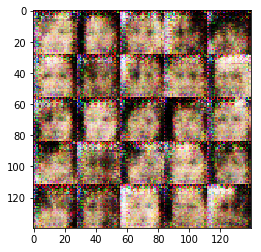




Current Epoch 1/1 
 Discriminator Loss is : 0.3722 
 Generator Loss is : 4.0905



Current Epoch 1/1 
 Discriminator Loss is : 0.3619 
 Generator Loss is : 4.1963



Current Epoch 1/1 
 Discriminator Loss is : 0.3692 
 Generator Loss is : 4.0353



Current Epoch 1/1 
 Discriminator Loss is : 0.3690 
 Generator Loss is : 3.9598



Current Epoch 1/1 
 Discriminator Loss is : 0.3790 
 Generator Loss is : 3.7800


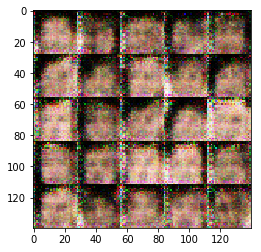




Current Epoch 1/1 
 Discriminator Loss is : 0.3834 
 Generator Loss is : 4.0601



Current Epoch 1/1 
 Discriminator Loss is : 0.3775 
 Generator Loss is : 3.7883



Current Epoch 1/1 
 Discriminator Loss is : 0.3774 
 Generator Loss is : 3.6072



Current Epoch 1/1 
 Discriminator Loss is : 0.3681 
 Generator Loss is : 3.8891



Current Epoch 1/1 
 Discriminator Loss is : 0.3635 
 Generator Loss is : 4.1063


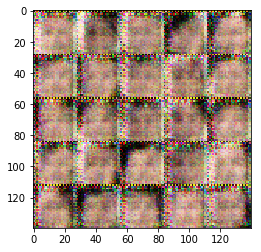




Current Epoch 1/1 
 Discriminator Loss is : 0.3603 
 Generator Loss is : 4.1918



Current Epoch 1/1 
 Discriminator Loss is : 0.3619 
 Generator Loss is : 4.0860



Current Epoch 1/1 
 Discriminator Loss is : 0.3501 
 Generator Loss is : 4.3222



Current Epoch 1/1 
 Discriminator Loss is : 0.3588 
 Generator Loss is : 4.3288



Current Epoch 1/1 
 Discriminator Loss is : 0.3553 
 Generator Loss is : 4.5369


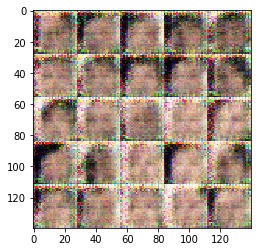




Current Epoch 1/1 
 Discriminator Loss is : 0.3544 
 Generator Loss is : 4.3442



Current Epoch 1/1 
 Discriminator Loss is : 0.3615 
 Generator Loss is : 4.0516



Current Epoch 1/1 
 Discriminator Loss is : 0.3520 
 Generator Loss is : 4.6182



Current Epoch 1/1 
 Discriminator Loss is : 0.3599 
 Generator Loss is : 4.0483



Current Epoch 1/1 
 Discriminator Loss is : 0.3616 
 Generator Loss is : 4.2156


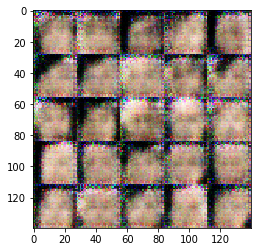




Current Epoch 1/1 
 Discriminator Loss is : 0.3542 
 Generator Loss is : 4.4395



Current Epoch 1/1 
 Discriminator Loss is : 0.3677 
 Generator Loss is : 3.7591



Current Epoch 1/1 
 Discriminator Loss is : 0.3527 
 Generator Loss is : 4.2911



Current Epoch 1/1 
 Discriminator Loss is : 0.3520 
 Generator Loss is : 4.9928



Current Epoch 1/1 
 Discriminator Loss is : 0.3655 
 Generator Loss is : 3.9050


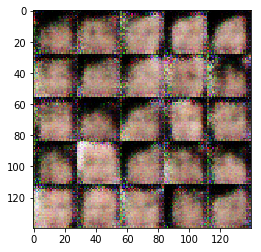




Current Epoch 1/1 
 Discriminator Loss is : 0.3606 
 Generator Loss is : 5.1943



Current Epoch 1/1 
 Discriminator Loss is : 0.3469 
 Generator Loss is : 5.0445



Current Epoch 1/1 
 Discriminator Loss is : 0.3527 
 Generator Loss is : 4.3828



Current Epoch 1/1 
 Discriminator Loss is : 0.3798 
 Generator Loss is : 3.8726



Current Epoch 1/1 
 Discriminator Loss is : 0.3637 
 Generator Loss is : 4.1266


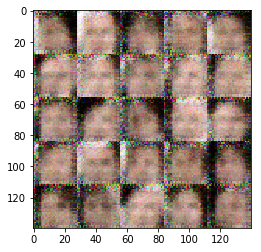




Current Epoch 1/1 
 Discriminator Loss is : 0.3513 
 Generator Loss is : 4.8436



Current Epoch 1/1 
 Discriminator Loss is : 0.3563 
 Generator Loss is : 4.3852



Current Epoch 1/1 
 Discriminator Loss is : 0.3573 
 Generator Loss is : 4.4264



Current Epoch 1/1 
 Discriminator Loss is : 0.3589 
 Generator Loss is : 4.4963



Current Epoch 1/1 
 Discriminator Loss is : 0.3604 
 Generator Loss is : 4.4268


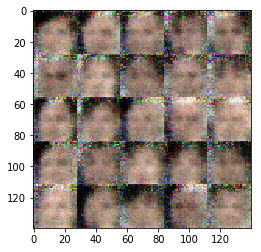




Current Epoch 1/1 
 Discriminator Loss is : 0.3750 
 Generator Loss is : 3.6275



Current Epoch 1/1 
 Discriminator Loss is : 0.3619 
 Generator Loss is : 4.6861



Current Epoch 1/1 
 Discriminator Loss is : 0.3803 
 Generator Loss is : 5.2440



Current Epoch 1/1 
 Discriminator Loss is : 0.3645 
 Generator Loss is : 3.9469



Current Epoch 1/1 
 Discriminator Loss is : 0.3554 
 Generator Loss is : 4.7831


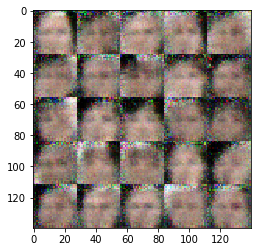




Current Epoch 1/1 
 Discriminator Loss is : 0.3549 
 Generator Loss is : 4.3498



Current Epoch 1/1 
 Discriminator Loss is : 0.3599 
 Generator Loss is : 4.0789



Current Epoch 1/1 
 Discriminator Loss is : 0.3522 
 Generator Loss is : 4.6960



Current Epoch 1/1 
 Discriminator Loss is : 0.3706 
 Generator Loss is : 3.8812



Current Epoch 1/1 
 Discriminator Loss is : 0.3657 
 Generator Loss is : 4.0822


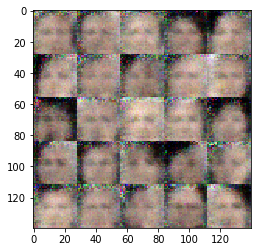




Current Epoch 1/1 
 Discriminator Loss is : 0.3655 
 Generator Loss is : 5.5783



Current Epoch 1/1 
 Discriminator Loss is : 0.3904 
 Generator Loss is : 3.5395



Current Epoch 1/1 
 Discriminator Loss is : 0.3657 
 Generator Loss is : 4.1525



Current Epoch 1/1 
 Discriminator Loss is : 0.3635 
 Generator Loss is : 4.2585



Current Epoch 1/1 
 Discriminator Loss is : 0.3630 
 Generator Loss is : 4.2792


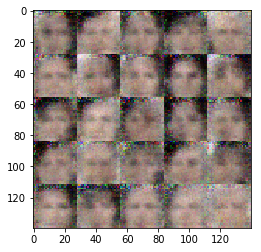




Current Epoch 1/1 
 Discriminator Loss is : 0.3544 
 Generator Loss is : 4.3731



Current Epoch 1/1 
 Discriminator Loss is : 0.3643 
 Generator Loss is : 4.1588



Current Epoch 1/1 
 Discriminator Loss is : 0.3648 
 Generator Loss is : 4.3645



Current Epoch 1/1 
 Discriminator Loss is : 0.3743 
 Generator Loss is : 4.1283



Current Epoch 1/1 
 Discriminator Loss is : 0.3668 
 Generator Loss is : 4.1386


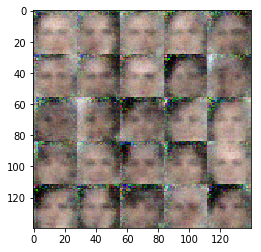




Current Epoch 1/1 
 Discriminator Loss is : 0.4452 
 Generator Loss is : 3.1119



Current Epoch 1/1 
 Discriminator Loss is : 0.3877 
 Generator Loss is : 3.8646



Current Epoch 1/1 
 Discriminator Loss is : 0.3732 
 Generator Loss is : 4.1049



Current Epoch 1/1 
 Discriminator Loss is : 0.3737 
 Generator Loss is : 4.1661



Current Epoch 1/1 
 Discriminator Loss is : 0.3867 
 Generator Loss is : 3.7533


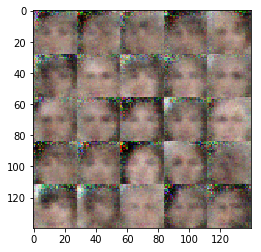




Current Epoch 1/1 
 Discriminator Loss is : 0.3752 
 Generator Loss is : 4.1454



Current Epoch 1/1 
 Discriminator Loss is : 0.3896 
 Generator Loss is : 4.3572



Current Epoch 1/1 
 Discriminator Loss is : 0.3894 
 Generator Loss is : 4.2740



Current Epoch 1/1 
 Discriminator Loss is : 0.4163 
 Generator Loss is : 4.6816



Current Epoch 1/1 
 Discriminator Loss is : 0.5720 
 Generator Loss is : 3.4889


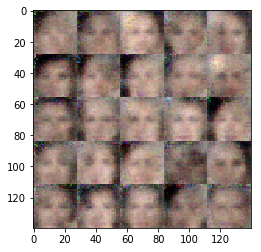




Current Epoch 1/1 
 Discriminator Loss is : 0.4018 
 Generator Loss is : 3.9631



Current Epoch 1/1 
 Discriminator Loss is : 0.4107 
 Generator Loss is : 4.1985



Current Epoch 1/1 
 Discriminator Loss is : 0.4106 
 Generator Loss is : 3.5834



Current Epoch 1/1 
 Discriminator Loss is : 0.4150 
 Generator Loss is : 3.3583



Current Epoch 1/1 
 Discriminator Loss is : 0.4099 
 Generator Loss is : 3.6395


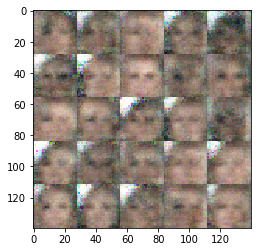




Current Epoch 1/1 
 Discriminator Loss is : 0.4340 
 Generator Loss is : 3.9056



Current Epoch 1/1 
 Discriminator Loss is : 0.4481 
 Generator Loss is : 3.6210



Current Epoch 1/1 
 Discriminator Loss is : 0.5080 
 Generator Loss is : 2.9496



Current Epoch 1/1 
 Discriminator Loss is : 0.4606 
 Generator Loss is : 3.6041



Current Epoch 1/1 
 Discriminator Loss is : 0.4545 
 Generator Loss is : 3.6988


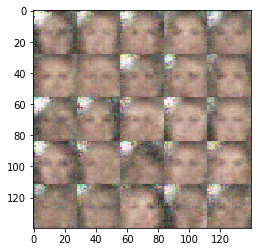




Current Epoch 1/1 
 Discriminator Loss is : 0.5109 
 Generator Loss is : 2.7789



Current Epoch 1/1 
 Discriminator Loss is : 0.4347 
 Generator Loss is : 3.5438



Current Epoch 1/1 
 Discriminator Loss is : 0.4635 
 Generator Loss is : 3.3833



Current Epoch 1/1 
 Discriminator Loss is : 0.4442 
 Generator Loss is : 3.8055



Current Epoch 1/1 
 Discriminator Loss is : 0.4527 
 Generator Loss is : 3.2975


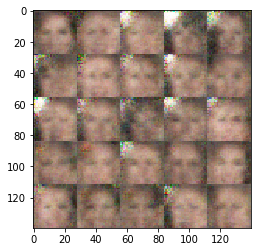




Current Epoch 1/1 
 Discriminator Loss is : 0.4282 
 Generator Loss is : 3.5099



Current Epoch 1/1 
 Discriminator Loss is : 0.5197 
 Generator Loss is : 2.5344



Current Epoch 1/1 
 Discriminator Loss is : 0.4910 
 Generator Loss is : 3.2463



Current Epoch 1/1 
 Discriminator Loss is : 0.6199 
 Generator Loss is : 2.9214



Current Epoch 1/1 
 Discriminator Loss is : 0.8395 
 Generator Loss is : 2.2855


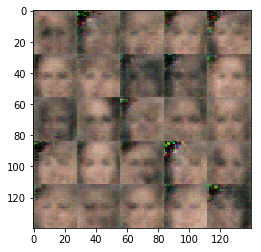




Current Epoch 1/1 
 Discriminator Loss is : 0.5781 
 Generator Loss is : 3.1062



Current Epoch 1/1 
 Discriminator Loss is : 0.4429 
 Generator Loss is : 3.4644



Current Epoch 1/1 
 Discriminator Loss is : 0.5134 
 Generator Loss is : 2.6529



Current Epoch 1/1 
 Discriminator Loss is : 0.4822 
 Generator Loss is : 2.9076



Current Epoch 1/1 
 Discriminator Loss is : 0.4361 
 Generator Loss is : 3.3454


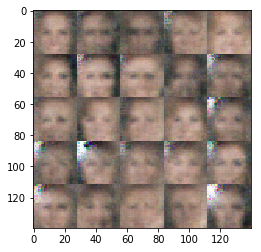




Current Epoch 1/1 
 Discriminator Loss is : 0.4691 
 Generator Loss is : 3.0927



Current Epoch 1/1 
 Discriminator Loss is : 0.4320 
 Generator Loss is : 3.2773



Current Epoch 1/1 
 Discriminator Loss is : 0.4962 
 Generator Loss is : 3.1767



Current Epoch 1/1 
 Discriminator Loss is : 0.4702 
 Generator Loss is : 2.9087



Current Epoch 1/1 
 Discriminator Loss is : 0.4569 
 Generator Loss is : 3.1902


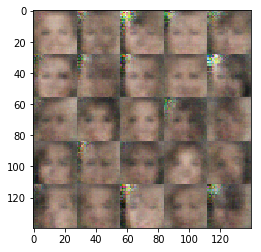




Current Epoch 1/1 
 Discriminator Loss is : 0.4523 
 Generator Loss is : 3.4928



Current Epoch 1/1 
 Discriminator Loss is : 0.5051 
 Generator Loss is : 2.7837



Current Epoch 1/1 
 Discriminator Loss is : 0.6160 
 Generator Loss is : 2.3929



Current Epoch 1/1 
 Discriminator Loss is : 0.8242 
 Generator Loss is : 2.0793



Current Epoch 1/1 
 Discriminator Loss is : 0.6932 
 Generator Loss is : 2.0130


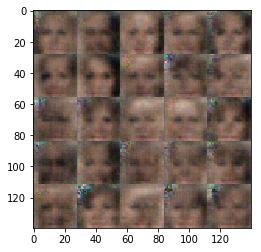




Current Epoch 1/1 
 Discriminator Loss is : 0.5210 
 Generator Loss is : 2.5567



Current Epoch 1/1 
 Discriminator Loss is : 0.6145 
 Generator Loss is : 2.7924



Current Epoch 1/1 
 Discriminator Loss is : 0.4406 
 Generator Loss is : 3.2835



Current Epoch 1/1 
 Discriminator Loss is : 0.4689 
 Generator Loss is : 3.4971



Current Epoch 1/1 
 Discriminator Loss is : 0.4703 
 Generator Loss is : 3.1297


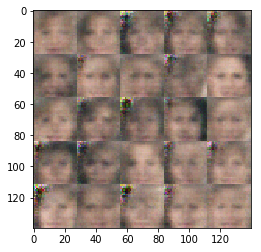




Current Epoch 1/1 
 Discriminator Loss is : 0.4632 
 Generator Loss is : 2.9682



Current Epoch 1/1 
 Discriminator Loss is : 0.4803 
 Generator Loss is : 3.1002



Current Epoch 1/1 
 Discriminator Loss is : 0.4445 
 Generator Loss is : 3.5491



Current Epoch 1/1 
 Discriminator Loss is : 0.5645 
 Generator Loss is : 2.2728



Current Epoch 1/1 
 Discriminator Loss is : 0.5077 
 Generator Loss is : 2.5346


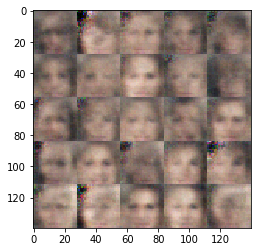




Current Epoch 1/1 
 Discriminator Loss is : 0.4822 
 Generator Loss is : 2.7974



Current Epoch 1/1 
 Discriminator Loss is : 0.5156 
 Generator Loss is : 3.5086



Current Epoch 1/1 
 Discriminator Loss is : 0.4509 
 Generator Loss is : 3.2126



Current Epoch 1/1 
 Discriminator Loss is : 0.4666 
 Generator Loss is : 2.8978



Current Epoch 1/1 
 Discriminator Loss is : 0.4821 
 Generator Loss is : 2.7448


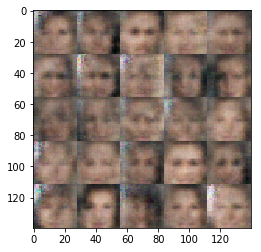




Current Epoch 1/1 
 Discriminator Loss is : 0.5789 
 Generator Loss is : 2.0170



Current Epoch 1/1 
 Discriminator Loss is : 0.5674 
 Generator Loss is : 2.4789



Current Epoch 1/1 
 Discriminator Loss is : 0.4675 
 Generator Loss is : 2.5773



Current Epoch 1/1 
 Discriminator Loss is : 0.4484 
 Generator Loss is : 2.8828



Current Epoch 1/1 
 Discriminator Loss is : 0.4842 
 Generator Loss is : 2.9569


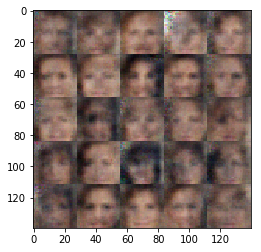




Current Epoch 1/1 
 Discriminator Loss is : 0.4736 
 Generator Loss is : 3.2716



Current Epoch 1/1 
 Discriminator Loss is : 0.4824 
 Generator Loss is : 2.7662



Current Epoch 1/1 
 Discriminator Loss is : 0.5230 
 Generator Loss is : 2.8069



Current Epoch 1/1 
 Discriminator Loss is : 0.4504 
 Generator Loss is : 3.2828



Current Epoch 1/1 
 Discriminator Loss is : 0.4905 
 Generator Loss is : 2.7159


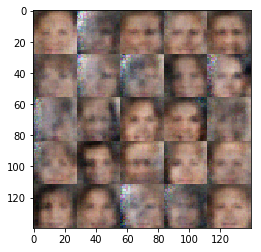




Current Epoch 1/1 
 Discriminator Loss is : 0.5209 
 Generator Loss is : 2.5356



Current Epoch 1/1 
 Discriminator Loss is : 0.4753 
 Generator Loss is : 2.9644



Current Epoch 1/1 
 Discriminator Loss is : 0.6100 
 Generator Loss is : 2.0273



Current Epoch 1/1 
 Discriminator Loss is : 0.5060 
 Generator Loss is : 2.7853



Current Epoch 1/1 
 Discriminator Loss is : 0.4914 
 Generator Loss is : 2.8923


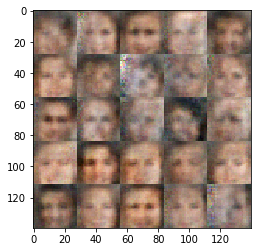




Current Epoch 1/1 
 Discriminator Loss is : 0.5405 
 Generator Loss is : 2.1149



Current Epoch 1/1 
 Discriminator Loss is : 0.4621 
 Generator Loss is : 2.5578



Current Epoch 1/1 
 Discriminator Loss is : 0.5676 
 Generator Loss is : 2.6400



Current Epoch 1/1 
 Discriminator Loss is : 0.6880 
 Generator Loss is : 1.4325



Current Epoch 1/1 
 Discriminator Loss is : 0.4838 
 Generator Loss is : 2.5670


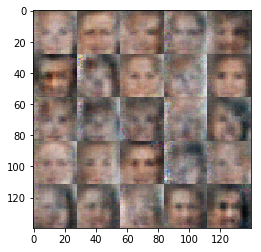




Current Epoch 1/1 
 Discriminator Loss is : 0.8297 
 Generator Loss is : 2.4673



Current Epoch 1/1 
 Discriminator Loss is : 0.7586 
 Generator Loss is : 3.1718



Current Epoch 1/1 
 Discriminator Loss is : 0.5361 
 Generator Loss is : 2.0021



Current Epoch 1/1 
 Discriminator Loss is : 0.6794 
 Generator Loss is : 2.5819



Current Epoch 1/1 
 Discriminator Loss is : 1.0343 
 Generator Loss is : 3.9717


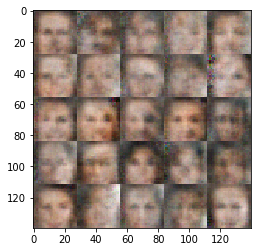




Current Epoch 1/1 
 Discriminator Loss is : 1.2430 
 Generator Loss is : 0.6591



Current Epoch 1/1 
 Discriminator Loss is : 0.5727 
 Generator Loss is : 1.8464





In [252]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

### My personal oppion
Actually, I didn't approve this result, I had spent more than 2 day to tune the hyper paramenters, and tried servel sturcture to experience the model, but DCGAN seems like the black box. Behold, there's a black magic called DCGAN. But a week ago, I read about an paper about BEGAN.
I saw the incrablly result of face generation, so I want to try it.

In [67]:
import glob
import time
import numpy as np
import tensorflow as tf

def conv2d(x, filter_shape, bias=True, stride=1, padding="SAME", name="conv2d"):
    kw, kh, nin, nout = filter_shape
    pad_size = (kw - 1) / 2

    if padding == "VALID":
        x = tf.pad(x, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], "SYMMETRIC")

    initializer = tf.random_normal_initializer(0., 0.02)
    with tf.variable_scope(name):
        weight = tf.get_variable("weight", shape=filter_shape, initializer=initializer)
        x = tf.nn.conv2d(x, weight, [1, stride, stride, 1], padding=padding)

        if bias:
            b = tf.get_variable("bias", shape=filter_shape[-1], initializer=tf.constant_initializer(0.))
            x = tf.nn.bias_add(x, b)
    return x

def fc(x, output_shape, bias=True, name='fc'):
    shape = x.get_shape().as_list()
    dim = np.prod(shape[1:])
    x = tf.reshape(x, [-1, dim])
    input_shape = dim

    initializer = tf.random_normal_initializer(0., 0.02)
    with tf.variable_scope(name):
        weight = tf.get_variable("weight", shape=[input_shape, output_shape], initializer=initializer)
        x = tf.matmul(x, weight)

        if bias:
            b = tf.get_variable("bias", shape=[output_shape], initializer=tf.constant_initializer(0.))
            x = tf.nn.bias_add(x, b)
    return x

def pool(x, r=2, s=1):
    return tf.nn.avg_pool(x, ksize=[1, r, r, 1], strides=[1, s, s, 1], padding="SAME")


def l1_loss(x, y):
    return tf.reduce_mean(tf.abs(x - y))


def resize_nn(x, size):
    return tf.image.resize_nearest_neighbor(x, size=(int(size), int(size)))

In [68]:
def generator_Bgcen(x, reuse=None, data_size = 64, filter_number=64):
    with tf.variable_scope('generator') as scope:
        if reuse:
            scope.reuse_variables()

        w = data_size
        f = filter_number
        p = "SAME"

        x = fc(x, 8 * 8 * f, name='fc')
        x = tf.reshape(x, [-1, 8, 8, f])

        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv1_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = resize_nn(x, w / 8)
            x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv2_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv2_b')
            x = tf.nn.elu(x)

        x = resize_nn(x, w / 4)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv3_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv3_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w / 2)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv4_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p, name='conv4_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv5_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv5_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, 3], stride=1,  padding=p,name='conv6_a')
    return x

In [69]:
def encoder(x, reuse=None, data_size=64, filter_number=64, embedding=64):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        f = filter_number
        h = embedding
        p = "SAME"

        x = conv2d(x, [3, 3, 3, f], stride=1,  padding=p,name='conv1_enc_a')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv2_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1,  padding=p,name='conv2_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, f, 2 * f], stride=1,  padding=p,name='conv3_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 2 * f, 2 * f], stride=1,  padding=p,name='conv3_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 2 * f, 2 * f], stride=1,  padding=p,name='conv3_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, 2 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 3 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 3 * f, 3 * f], stride=1,  padding=p,name='conv4_enc_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [1, 1, 3 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_0')
        x = pool(x, r=2, s=2)
        x = conv2d(x, [3, 3, 4 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, 4 * f, 4 * f], stride=1,  padding=p,name='conv5_enc_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = conv2d(x, [1, 1, 4 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_0')
            x = pool(x, r=2, s=2)
            x = conv2d(x, [3, 3, 5 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, 5 * f, 5 * f], stride=1,  padding=p,name='conv6_enc_b')
            x = tf.nn.elu(x)

        x = fc(x, h, name='enc_fc')
    return x

In [70]:
def decoder(x, reuse=None, data_size=64, filter_number=64):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        w = data_size
        f = filter_number
        p = "SAME"

        x = fc(x, 8 * 8 * f, name='fc')
        x = tf.reshape(x, [-1, 8, 8, f])

        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv1_b')
        x = tf.nn.elu(x)

        if data_size == 128:
            x = resize_nn(x, w / 8)
            x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv2_a')
            x = tf.nn.elu(x)
            x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv2_b')
            x = tf.nn.elu(x)

            x = resize_nn(x, w / 4)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv3_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv3_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w / 2)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv4_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv4_b')
        x = tf.nn.elu(x)

        x = resize_nn(x, w)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv5_a')
        x = tf.nn.elu(x)
        x = conv2d(x, [3, 3, f, f], stride=1, padding=p, name='conv5_b')
        x = tf.nn.elu(x)

        x = conv2d(x, [3, 3, f, 3], stride=1, padding=p, name='conv6_a')
    return x

In [12]:
#Misc
flag = True
gpu_number = 0
image_size = 64

# Train Iteration
niter = 50
niter_snapshot = 2440
max_to_keep = 5

#Train Parameter
batch_size = 16
learning_rate = 1e-4
mm = 0.5 #momentum
mm2 = 0.5 #momentum2
lamda = 0.001
gamma = 0.5
filter_number = 64
input_size = 64
embedding = 64

In [13]:
def Model_Input(batch_size, input_size, data_size):
    x = tf.placeholder(tf.float32, shape=[batch_size, input_size], name='x')
    y = tf.placeholder(tf.float32, shape=[batch_size, data_size, data_size, 3], name='y')
    kt = tf.placeholder(tf.float32, name='kt')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return x, y, kt, learning_rate

In [47]:
def Model_Loss(y, gen, d_real, d_fake, kt, gamma):
    d_real_loss = l1_loss(y, d_real)
    d_fake_loss = l1_loss(gen, d_fake)
    d_loss = d_real_loss - kt * d_fake_loss
    m_global = d_real_loss + tf.abs(gamma * d_real_loss - d_fake_loss)
    return d_real_loss, d_fake_loss, d_loss, m_global

In [49]:
def Optimizer_BEGAN(g_vars, d_vars, lr, mm, g_loss, d_loss):
    opt_g = tf.train.AdamOptimizer(lr, mm).minimize(g_loss, var_list=g_vars)
    opt_d = tf.train.AdamOptimizer(lr, mm).minimize(d_loss, var_list=d_vars)
    return opt_g, opt_d

In [77]:
merged = None
writer = None
def train(sess_, batch_size, get_batches, input_size, image_size, gamma, lamda, lr, mm, filter_number, data_shape, data_image_mode, embedding, 
          niter, niter_snapshot,  flag=True, Max_to_keep=10):
    _x, _y, _kt, _lr = Model_Input(batch_size, input_size, image_size)
    
    _recon_gen = generator_Bgcen(_x, filter_number=filter_number, data_size=image_size)
    _d_real = decoder(encoder(_y, data_size=image_size, embedding=embedding, filter_number=filter_number), 
                    filter_number=filter_number, data_size=image_size)
    _d_fake = decoder(encoder(_recon_gen, reuse=True, embedding=embedding, data_size=image_size, filter_number=filter_number), 
                    reuse=True, filter_number=filter_number,data_size=image_size)
    _recon_dec = decoder(_x, reuse=True, filter_number=filter_number, data_size=image_size)
    
    _d_real_loss, _d_fake_loss, _d_loss, _m_global = Model_Loss(_y, _recon_gen, _d_real, _d_fake, _kt, gamma)
    _g_loss = _d_fake_loss
    
    _g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "generator")
    _d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "discriminator")
    
    _opt_g, _opt_d = Optimizer_BEGAN(_g_vars, _d_vars, _lr, mm, _g_loss, _d_loss)
    
    sess_.run(tf.global_variables_initializer())
    
    saver =  tf.train.Saver(max_to_keep=(Max_to_keep))
    
    if flag:
        tf.summary.scalar('loss/loss', _d_loss + _g_loss)
        tf.summary.scalar('loss/g_loss', _g_loss)
        tf.summary.scalar('loss/d_loss', _d_loss)
        tf.summary.scalar('loss/d_real_loss', _d_real_loss)
        tf.summary.scalar('loss/d_fake_loss', _d_fake_loss)
        tf.summary.scalar('misc/kt', _kt)
        tf.summary.scalar('misc/m_global', _m_global)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter(".", sess_.graph)
    
    start_time = time.time()
    kt_ = np.float32(0.)
    lr_ = np.float32(lr)
    count = 0
    
    for epoch in range (niter):
        m = 0
        for batch_images in get_batches(batch_size):
            count += 1
            m += 1
            batch_x = np.random.uniform(-1, 1, size=[batch_size, input_size])
            #batch_files = data[idx * self.batch_size: (idx + 1) * self.batch_size]
            #batch_data = [get_image(batch_file) for batch_file in batch_files]
            
            g_opt = [_opt_g, _g_loss, _d_real_loss, _d_fake_loss]
            d_opt = [_opt_d, _d_loss, merged]
            feed_dict = {_x: batch_x, _y: batch_images, _kt: kt_, _lr: lr}
            
            #train the model
            _, loss_g, d_real_loss, d_fake_loss = sess_.run(g_opt, feed_dict=feed_dict)
            _, loss_d, summary = sess_.run(d_opt, feed_dict=feed_dict)
            
            # update kt, m_global
            kt = np.maximum(np.minimum(1., kt_ + lamda * (gamma * d_real_loss - d_fake_loss)), 0.)
            m_global = d_real_loss + np.abs(gamma * d_real_loss - d_fake_loss)
            loss = loss_g + loss_d
            
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, "
                      "loss: %.4f, loss_g: %.4f, loss_d: %.4f, d_real: %.4f, d_fake: %.4f, kt: %.8f, M: %.8f"
                      % (epoch, m, count, time.time() - start_time,
                         loss, loss_g, loss_d, d_real_loss, d_fake_loss, kt, m_global))
            writer.add_summary(summary, count)
            
            if count % niter_snapshot == (niter_snapshot - 1):
                    # update learning rate
                    lr *= 0.95
            
            if count%5 == 0:
                    print("Current Epoch {}/{} \n".format(epoch, niter),
                          "Discriminator Loss is : {:.4f} \n".format(loss_d),
                          "Generator Loss is : {:.4f}".format(loss_g))
                    if count%25 == 0:
                        print('\n')
                        #show_generator_output(sess_, 25, _x, data_shape[3], data_image_mode)
                    print("\n")

def test(self, train_flag=True):
        # generate output
        img_num = self.batch_size
        img_size = self.data_size

        output_f = int(np.sqrt(img_num))
        im_output_gen = np.zeros([img_size * output_f, img_size * output_f, 3])
        im_output_dec = np.zeros([img_size * output_f, img_size * output_f, 3])

        test_data = np.random.uniform(-1., 1., size=[img_num, self.input_size])
        output_gen = (self.sess.run(self.recon_gen, feed_dict={self.x: test_data}))  # generator output
        output_dec = (self.sess.run(self.recon_dec, feed_dict={self.x: test_data}))  # decoder output

        output_gen = [inverse_image(output_gen[i]) for i in range(img_num)]
        output_dec = [inverse_image(output_dec[i]) for i in range(img_num)]

        for i in range(output_f):
            for j in range(output_f):
                im_output_gen[i * img_size:(i + 1) * img_size, j * img_size:(j + 1) * img_size, :] \
                    = output_gen[j + (i * output_f)]
                im_output_dec[i * img_size:(i + 1) * img_size, j * img_size:(j + 1) * img_size, :] \
                    = output_dec[j + (i * output_f)]

        # output save
        if train_flag:
            scm.imsave(self.project_dir + '/result/' + str(self.count) + '_output.bmp', im_output_gen)
        else:
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%Y-%m-%d_%H:%M:%S')
            scm.imsave(self.project_dir + '/result_test/gen_{}_output.bmp'.format(nowDatetime), im_output_gen)
            scm.imsave(self.project_dir + '/result_test/dec_{}_output.bmp'.format(nowDatetime), im_output_dec)

In [78]:
#Misc
flag = True
gpu_number = 0
image_size = 28

# Train Iteration
niter = 50
niter_snapshot = 2440
max_to_keep = 5

#Train Parameter
batch_size = 128
learning_rate = 1e-4
mm = 0.5 #momentum
mm2 = 0.5 #momentum2
lamda = 0.001
gamma = 0.4
filter_number = 28
input_size = 128
embedding = 128

Max_to_keep = 100

#celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    with tf.Session() as sess:
        train(sess, batch_size, celeba_dataset.get_batches, input_size, image_size, gamma, lamda, learning_rate, mm, filter_number,
              celeba_dataset.shape, celeba_dataset.image_mode, embedding, niter, niter_snapshot, flag, Max_to_keep)

Epoch: [ 0] [   1/   1] time: 0.7310, loss: 0.2137, loss_g: 0.0000, loss_d: 0.2137, d_real: 0.2137, d_fake: 0.0000, kt: 0.00008549, M: 0.29922922
Epoch: [ 0] [   2/   2] time: 1.1160, loss: 0.2176, loss_g: 0.0002, loss_d: 0.2174, d_real: 0.2174, d_fake: 0.0002, kt: 0.00008672, M: 0.30412095
Epoch: [ 0] [   3/   3] time: 1.5010, loss: 0.2246, loss_g: 0.0003, loss_d: 0.2243, d_real: 0.2243, d_fake: 0.0003, kt: 0.00008942, M: 0.31370890
Epoch: [ 0] [   4/   4] time: 1.8910, loss: 0.2201, loss_g: 0.0003, loss_d: 0.2198, d_real: 0.2198, d_fake: 0.0003, kt: 0.00008756, M: 0.30733301
Epoch: [ 0] [   5/   5] time: 2.2760, loss: 0.2168, loss_g: 0.0004, loss_d: 0.2164, d_real: 0.2164, d_fake: 0.0004, kt: 0.00008618, M: 0.30262537
Current Epoch 0/50 
 Discriminator Loss is : 0.2164 
 Generator Loss is : 0.0004


Epoch: [ 0] [   6/   6] time: 2.6596, loss: 0.2245, loss_g: 0.0005, loss_d: 0.2241, d_real: 0.2241, d_fake: 0.0005, kt: 0.00008918, M: 0.31326916
Epoch: [ 0] [   7/   7] time: 3.0386, los

KeyboardInterrupt: 